## **Default Settings**

In [69]:
!pip install -q transformers
# !pip install -q --upgrade matplotlib

In [1]:
import transformers

import copy
import easydict
import missingno
import re
import string
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/ColabNotebooks/mia/kakaobrain-kogpt-KoGPT6B-ryan1.5b-float16-20220523-183727-bs24-rs1-n50000-k100.csv" "./df1.csv"
!cp "/content/drive/MyDrive/ColabNotebooks/mia/kakaobrain-kogpt-KoGPT6B-ryan1.5b-float16-20220524-000357-bs24-rs1-n50000-k100.csv" "./df2.csv"

# !cp "/content/drive/MyDrive/ColabNotebooks/mia/top-k-all.csv" "./top-k-all.csv"

In [2]:
args = easydict.EasyDict({
    "kakao": {
        "path1": "df1.csv",
        "path2": "df2.csv",
    },
})

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "kakaobrain/kogpt",
    revision="KoGPT6B-ryan1.5b-float16",
    bos_token="[BOS]",
    eos_token="[EOS]",
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]",
)

In [4]:
df1 = pd.read_csv(args.kakao.path1, encoding="utf-8")
df2 = pd.read_csv(args.kakao.path2, encoding="utf-8")
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df = df.loc[:, ["text", "ppl", "zlib_entropy", "ppl_lower", "sliding_window", "score1", "score2", "score3", "score4"]]

# df = pd.read_csv(args.kakao.path, encoding="utf-8")
df = df.drop_duplicates(subset=["text"]).sort_values(by="score2", ascending=False).reset_index(drop=True)
df.head()

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4
0,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.015625,708,1.390625,1.036133,-0.015504,45665.085257,21.268661,-0.035495
1,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,642,2.632812,1.036133,-0.017425,36842.734412,55.554061,-0.035495
2,그의 결혼식 일요일인데 너무일찍 눈이 떠진다 했습니다. 잠을 자지 않은것처럼 머리가...,1.017578,623,1.017578,1.088867,-0.017425,35752.373113,1.000000,-0.085138
3,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,722,1.272461,1.036133,-0.020300,35565.873842,11.869385,-0.035495
4,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.022461,699,1.413086,1.036133,-0.022212,31468.901790,15.566793,-0.035495


In [5]:
df.shape

(99976, 9)

In [31]:
df.columns

Index(['text', 'ppl', 'zlib_entropy', 'ppl_lower', 'sliding_window', 'score1',
       'score2', 'score3', 'score4', 'score1_top_k', 'score1_top_k_bpe',
       'score2_top_k', 'score2_top_k_bpe', 'score3_top_k', 'score3_top_k_bpe',
       'score4_top_k', 'score4_top_k_bpe'],
      dtype='object')

In [30]:
def calculate_similarity(str1: str, str2: str, n_gram: int = 3, is_word_level: bool = True) -> bool:
    global tokenizer

    def _word_level_tokenization(sentence) -> list:
        return re.split(r"[\s]+|[.,!?;]", sentence)


    def _bpe_token_level_tokenization(sentence) -> list:
        return tokenizer.encode(sentence)

    if is_word_level:
        str1 = _word_level_tokenization(str1)
        str2 = _word_level_tokenization(str2)
    else:
        str1 = _bpe_token_level_tokenization(str1)
        str2 = _bpe_token_level_tokenization(str2)


    ## Calculate trigram similarity: str1 (reference) vs str2 (hyphothesis).
    ## It is same as "Is string 1 is similar with string 2?"
    n_gram_set = lambda x: [
        set(j for j in x[i : i + n_gram]) for i in range(len(x) - n_gram)
    ]

    s1 = n_gram_set(str1)
    s2 = n_gram_set(str2)

    ## Return true if str1 is similar (or duplicated) to str2 else false.
    ## It is not recommended to mark two strings as similar, trivially.
    return len([i for i in s1 if i in s2]) / len(s1)

In [37]:
foo = df.sort_values(by="score3", ascending=False).reset_index(drop=True)

pairs = []
for i in tqdm.tqdm(range(1000), desc="calculating"):
    for j in range(i):
        sim1 = calculate_similarity(
            foo.loc[i, "text"], 
            foo.loc[j, "text"], 
            is_word_level=True,
        )
        sim2 = calculate_similarity(
            foo.loc[i, "text"], 
            foo.loc[j, "text"], 
            is_word_level=False,
        )
        if sim1 < 0.5 and sim2 >= 0.5:
            pairs.append((foo.loc[i, "text"], foo.loc[j, "text"]))

calculating: 100%|██████████| 1000/1000 [41:29<00:00,  2.49s/it]


In [38]:
len(pairs)

122

In [49]:
a, b = pairs[23]
a, b

("The Jaguar Pro Series 2014 was a men's tennis tournament played on outdoor clay courts. It was the 10th edition of the Jaguar Pro Series, and was part of the International Series of the 2014 ATP Tour, offering a prize of $350,000. It took place in Key Biscayne, Florida, United States, on 24–29 June 2014.\nATP singles main draw entrants.\nOther entrants.\nThe following players received wildcards into the singles main draw:\nThe following players received entry as an alternate into the singles main draw:\nThe following players received entry from the qualifying draw:\nThe following players comprised the Lucky Losers entry draw:\nATP doubles main draw entrants.\nOther entrants.\nThe following pairs received wildcards into the doubles main draw:\nThe following players made their tournament entry through wildcards:\nThe following players received entry from the qualifying draw:\nThe following player received entry as lucky loser:\nWTA singles main draw entrants.\nOther entrants.\nThe foll

In [50]:
sim1 = calculate_similarity(a, b, is_word_level=True)
sim2 = calculate_similarity(a, b, is_word_level=False)

sim1, sim2

(0.47368421052631576, 0.5375494071146245)

In [51]:
import difflib 

In [64]:
class bcolors:
    RED = "\033[41m"
    GREEN = "\33[42m"
    ENDC = "\033[0m"
    
foo = a
bar = b

out = list(difflib.Differ().compare(foo, bar))
sp, ep = np.inf, np.inf

for j, i in enumerate(out):
    if i.startswith("- "):
        pass
        # print(i.replace("- ", ""), end="")
        # print(bcolors.RED + i.replace("- ", "") + bcolors.ENDC, end="")
        
    elif i.startswith("+ "):
        # pass
        print(i.replace("+ ", ""), end="")
        # print(bcolors.GREEN + i.replace("+ ", "") + bcolors.ENDC, end="")        
        
    else:
        sp = min(sp, j)
        print(bcolors.GREEN + i[2:] + bcolors.ENDC, end="")        
        # print(i[2:], end="")

The 2014 Sumter National Bank Boca Raton Dunkard was a professional tennis tournament played on outdoor hard courts. It was the 28th edition of the tournament and part of the 2014 ATP Challenger Tour and the 2014 ITF Women's Circuit, offering a total of $50,000+H (ATP)–$40, the third-highest ATP tournament on the 2014 ATP World Tour schedule, and a $60,000+H (ITF Women's Circuit)–H event on the 2013–14 ITF Women's Circuit. It took place in Port Arthur, United States between 22 August and 28 August 2014.
ATP singles main draw entrants.
Other entrants.
The following players received wildcards into the singles main draw:
The following players entered the singles main draw as an alternate:
The following players received entry as a special exempt:
The following players received entry as an invited:
WTA singles main draw entrants.
Other entrants.
The following players received wildcards into the singles main draw:
The following players received entry as a special exempt:
The following player

In [65]:
before_state = None

for j, i in enumerate(out):
    if i.startswith("- "):
        pass
        # if before_state == "hl" and j != 0:
        #     print("}", end="")
        #     before_state = "non_hl"

        # if i[2:] != "\n":
        #     print(i.replace("- ", ""), end="")
        # else:
        #     print("{\\textbackslash}n", end="")
        # print(bcolors.RED + i.replace("- ", "") + bcolors.ENDC, end="")
        
    elif i.startswith("+ "):
        pass
        if before_state == "hl" and j != 0:
            print("}", end="")
            before_state = "non_hl"

        if i[2:] != "\n":
            print(i.replace("+ ", ""), end="")
        else:
            print("{\\textbackslash}n", end="")
        # print(i.replace("+ ", ""), end="")
        # print(bcolors.GREEN + i.replace("+ ", "") + bcolors.ENDC, end="")        
        
    else:
        if before_state != "hl":
            print("\hl{", end="")
            before_state = "hl"

        sp = min(sp, j)
        if i[2:] != "\n":
            print(bcolors.GREEN + i[2:] + bcolors.ENDC, end="")
        else:
            print(bcolors.GREEN + "{\\textbackslash}n" + bcolors.ENDC, end="")

        # print(i[2:], end="")

\hl{The 2014 }Su\hl{m}t\hl{e}r Natio\hl{n}al Bank Boca Raton Dunkard wa\hl{s} a professional\hl{ tennis tournament played on outdoor }h\hl{a}rd\hl{ courts. It was the }28\hl{th edition of the to}u\hl{rna}m\hl{e}nt and pa\hl{r}t\hl{ of the 2014 ATP }Challenge\hl{r} Tour and the 2014 ITF Women's Circuit\hl{, offering a }total\hl{ of $}50,000+H (ATP)–$40, the third-highest ATP tournament on the 2014 ATP World Tour schedule, and a $60,000+H (ITF Women's Circuit)–H event on the 201\hl{3}–14 ITF Women's Circuit. It took place in Port Arthur\hl{, United States }betwee\hl{n 22 }A\hl{u}gust a\hl{n}d 28 August\hl{ 2014.{\textbackslash}nATP singles main draw entrants.{\textbackslash}nOther entrants.{\textbackslash}nThe following players received wildcards into the singles main draw:{\textbackslash}nThe following players entered} the singles m\hl{a}in dra\hl{w} as an alternate\hl{:{\textbackslash}nThe following players received entry a}s\hl{ a} special exempt\hl{:{\textbackslash}nThe following pla

In [54]:
class bcolors:
    RED = "\033[41m"
    GREEN = "\33[42m"
    ENDC = "\033[0m"
    
foo = a
bar = b

out = list(difflib.Differ().compare(foo, bar))
sp, ep = np.inf, np.inf

for j, i in enumerate(out):
    if i.startswith("- "):
        # pass
        print(i.replace("- ", ""), end="")
        # print(bcolors.RED + i.replace("- ", "") + bcolors.ENDC, end="")
        
    elif i.startswith("+ "):
        pass
        # print(i.replace("+ ", ""), end="")
        # print(bcolors.GREEN + i.replace("+ ", "") + bcolors.ENDC, end="")        
        
    else:
        sp = min(sp, j)
        print(bcolors.GREEN + i[2:] + bcolors.ENDC, end="")        
        # print(i[2:], end="")

The Jaguar Pro Series 2014 was a men's tennis tournament played on outdoor clay courts. It was the 10th edition of the Jaguar Pro Series, and was part of the International Series of the 2014 ATP Tour, offering a prize of $350,000. It took place in Key Biscayne, Florida, United States, on 24–29 June 2014.
ATP singles main draw entrants.
Other entrants.
The following players received wildcards into the singles main draw:
The following players received entry as an alternate into the singles main draw:
The following players received entry from the qualifying draw:
The following players comprised the Lucky Losers entry draw:
ATP doubles main draw entrants.
Other entrants.
The following pairs received wildcards into the doubles main draw:
The following players made their tournament entry through wildcards:
The following players received entry from the qualifying draw:
The following player received entry as lucky loser:
WTA singles main draw entrants.
Other entrants.
The following players rec

In [63]:
before_state = None

for j, i in enumerate(out):
    if i.startswith("- "):
        # pass
        if before_state == "hl" and j != 0:
            print("}", end="")
            before_state = "non_hl"

        if i[2:] != "\n":
            print(i.replace("- ", ""), end="")
        else:
            print("{\\textbackslash}n", end="")
        # print(bcolors.RED + i.replace("- ", "") + bcolors.ENDC, end="")
        
    elif i.startswith("+ "):
        pass
        # print(i.replace("+ ", ""), end="")
        # print(bcolors.GREEN + i.replace("+ ", "") + bcolors.ENDC, end="")        
        
    else:
        if before_state != "hl":
            print("\hl{", end="")
            before_state = "hl"

        sp = min(sp, j)
        if i[2:] != "\n":
            print(bcolors.GREEN + i[2:] + bcolors.ENDC, end="")
        else:
            print(bcolors.GREEN + "{\\textbackslash}n" + bcolors.ENDC, end="")

        # print(i[2:], end="")

\hl{The} Jaguar Pro Series\hl{ 2014 }was a \hl{men}'\hl{s tennis tournament played on outdoor }cl\hl{a}y\hl{ courts. It was the }10\hl{th edition of the }Jaguar Pro Series, and was par\hl{t} \hl{o}f the Inte\hl{rna}tional S\hl{er}ies\hl{ of the 2014 ATP }Tou\hl{r, offering a }prize\hl{ of $3}50\hl{,}000. It took place in Key Biscayne, Florida,\hl{ United States},\hl{ }o\hl{n 2}4–\hl{2}9\hl{ }J\hl{un}e\hl{ 2014.{\textbackslash}nATP singles main draw entrants.{\textbackslash}nOther entrants.{\textbackslash}nThe following players received wildcards into the singles main draw:{\textbackslash}nThe following players }r\hl{e}ceived e\hl{nt}ry as an alt\hl{er}nat\hl{e} into the singles main \hl{d}r\hl{aw:{\textbackslash}nThe following players received entry }from the qu\hl{a}lifying\hl{ }dr\hl{a}w\hl{:{\textbackslash}nThe following players }comp\hl{r}is\hl{e}d the Lu\hl{c}k\hl{y }Losers entry dr\hl{a}w\hl{:{\textbackslash}nA}TP\hl{ }doub\hl{les main draw entrants.{\textbackslash}nOther entrant

In [47]:
for i, (a, b) in enumerate(pairs):
    print(f"[{i:03d}]: {a[:30]}")

[000]: 1. 제품명: SaintBall Park 2. 제품상태
[001]: 1. 제품명: SaintBall Park 2. 제품상태
[002]: 1. 제품명: SaintBall Park 2. 제품상태
[003]: 1. 제품명: SaintBall Park 2. 제품상태
[004]: 1. 제품명: SaintBall Park 2. 제품상태
[005]: 1. 제품명: SaintBall Park 2. 제품상태
[006]: 1. 제품명: SaintBall Park 2. 제품상태
[007]: 1. 제품명: SaintBall Park 2. 제품상태
[008]: 오늘 뉴스 마무리는 'Natizen 시사만평'으로↙ '
[009]: 1. 제품명: SaintBall Park 2. 제품상태
[010]: 오늘 뉴스 마무리는 'Natizen 시사만평'으로↙ '
[011]: 1. 제품명: SaintBall Park 2. 제품상태
[012]: 1. 제품명: SaintBall Park 2. 제품상태
[013]: 오늘 뉴스 마무리는 'Natizen 시사만평'으로↙ '
[014]: 1. 제품명: SaintBall Park 2. 제품상태
[015]: 1. 제품명: SaintBall Park 2. 제품상태
[016]: 1. 제품명: SaintBall Park 2. 제품상태
[017]: 1. 제품명: SaintBall Park 2. 제품상태
[018]: 1. 제품명: SaintBall Park 2. 제품상태
[019]: 우리가 잘 몰랐던 事實 이곳 미국 칼리포니아에 거주하는
[020]: 우리가 잘 몰랐던 事實 이곳 미국 칼리포니아에 거주하는
[021]: '한국 네티즌본부' 본 만평은 한국 네티즌본부에서 작성
[022]: '한국 네티즌본부' 본 만평은 한국 네티즌본부에서 작성
[023]: The Jaguar Pro Series 2014 was
[024]: 이 있겠사오나 무슨 일을 하든지 하느님께서 쉽게 할 수
[025]: 이 있겠사오나 무슨 일을 하든지 하느님께서 쉽게 할 수
[026]: 1. 제품

## **Duplicated Samples**

In [6]:
def calculate_similarity(str1: str, str2: str, n_gram: int = 3, is_word_level: bool = True) -> bool:
    global tokenizer

    def _word_level_tokenization(sentence) -> list:
        return re.split(r"[\s]+|[.,!?;]", sentence)


    def _bpe_token_level_tokenization(sentence) -> list:
        return tokenizer.encode(sentence)

    if is_word_level:
        str1 = _word_level_tokenization(str1)
        str2 = _word_level_tokenization(str2)
    else:
        str1 = _bpe_token_level_tokenization(str1)
        str2 = _bpe_token_level_tokenization(str2)


    ## Calculate trigram similarity: str1 (reference) vs str2 (hyphothesis).
    ## It is same as "Is string 1 is similar with string 2?"
    n_gram_set = lambda x: [
        set(j for j in x[i : i + n_gram]) for i in range(len(x) - n_gram)
    ]

    s1 = n_gram_set(str1)
    s2 = n_gram_set(str2)

    ## Return true if str1 is similar (or duplicated) to str2 else false.
    ## It is not recommended to mark two strings as similar, trivially.
    return len([i for i in s1 if i in s2]) / len(s1)


def deduplicate(foo: pd.DataFrame, column: str, total: int = 100) -> pd.DataFrame:
    ## Word-level deduplicating.
    
    ## Select and mark top-k.
    top_k_text = []
    top_k_idx = []

    foo = foo.sort_values(by=column, ascending=False).reset_index(drop=True)

    with tqdm.tqdm(desc="Deduplicating", total=total) as pbar:
        for idx, row in foo.iterrows():
            ## We only want top-k sentences.
            if len(top_k_text) >= total:
                break

            ## Big O complexity: O(n(n-1)/2) where n is k.
            if all([calculate_similarity(row["text"], text, is_word_level=True) < 0.5 for text in top_k_text]):
                top_k_text.append(row["text"])  ## save for comparison
                top_k_idx.append(idx)           ## save for marking

                ## Update probress bar.
                pbar.update(1)
    
    foo.loc[top_k_idx, f"{column}_top_k"] = np.arange(total)
    # foo.loc[:, f"{column}_top_k"] = foo.loc[:, f"{column}_top_k"].fillna("-")

    ## BPE token-level deduplicating.

    ## Select and mark top-k.
    top_k_text = []
    top_k_idx = []

    foo = foo.sort_values(by=column, ascending=False).reset_index(drop=True)

    with tqdm.tqdm(desc="Deduplicating", total=total) as pbar:
        for idx, row in foo.iterrows():
            ## We only want top-k sentences.
            if len(top_k_text) >= total:
                break

            ## Big O complexity: O(n(n-1)/2) where n is k.
            if all([calculate_similarity(row["text"], text, is_word_level=False) < 0.5 for text in top_k_text]):
                top_k_text.append(row["text"])  ## save for comparison
                top_k_idx.append(idx)           ## save for marking

                ## Update probress bar.
                pbar.update(1)
    
    foo.loc[top_k_idx, f"{column}_top_k_bpe"] = np.arange(total)
    # foo.loc[:, f"{column}_top_k"] = foo.loc[:, f"{column}_top_k"].fillna("-")

    return foo

In [7]:
%%time
df = df.loc[:, ["text", "ppl", "zlib_entropy", "ppl_lower", "sliding_window"]]

df.loc[:, "score1"] = -np.log(df.loc[:, "ppl"])
df.loc[:, "score2"] = df.loc[:, "zlib_entropy"] / np.log(df.loc[:, "ppl"])
df.loc[:, "score3"] = np.log(df.loc[:, "ppl_lower"]) / np.log(df.loc[:, "ppl"])
df.loc[:, "score4"] = -np.log(df.loc[:, "sliding_window"])

for metric in ["score1", "score2", "score3", "score4"]:
    # df.loc[:, metric] = score
    df = deduplicate(df, column=metric)
    
    _ = (
        df.loc[~df.loc[:, f"{metric}_top_k"].isna(), ["text", metric]]
         .sort_values(by=metric, ascending=False)
         .reset_index(drop=True)
         .to_csv(f"{metric}.csv", encoding="utf-8")
    )

    # try:
    #     from google.colab import files
    #     files.download(f"{metric}.csv")
    # except:
    #     pass

Deduplicating: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]

CPU times: user 2min 30s, sys: 872 ms, total: 2min 31s
Wall time: 2min 35s


## **Selected Samples**

In [14]:
df

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score1_top_k_bpe,score2_top_k,score2_top_k_bpe,score3_top_k,score3_top_k_bpe,score4_top_k,score4_top_k_bpe
0,이번에 새로 산 거는요....^^; (새로 산거고 다른거고..) 아참.. 제 이름은...,4.125000,476,4.125000,1.024414,-1.417066,335.905310,1.000000,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,제가 쓰는 이 소설 속엔 사람들이 잘 생각하지 못하는 것들이 담겨 있는 듯이 생각됩...,3.675781,368,3.675781,1.024414,-1.301766,282.692962,1.000000,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
2,(런던.AFP=연합) 최근 발생한 런던 폭탄 테러가 영국 국민의 단결을 요구한 보리...,3.736328,517,4.039062,1.024414,-1.318103,392.230247,1.059107,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
3,이 사고로 이씨와 조씨 및 김모(57·여)씨 등 3명이 중상을 입어 인근 병원으로 ...,2.498047,467,3.039062,1.024414,-0.915509,510.098655,1.214132,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
4,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,3.068359,651,4.125000,1.036133,-1.121143,580.657412,1.263948,-0.035495,NaN,NaN,NaN,NaN,NaN,NaN,12.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99971,안녕하세요! ​ 이번 포스팅 주제는 우리집 새단장 하기!! ​ 몇년 동안 사용해서 ...,10.921875,628,10.921875,18.578125,-2.390768,262.677135,1.000000,-2.921985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99972,안녕하세요: ^ 3_ 이 좋은 주말에.. 정말 정말 정말 너무 너무 우울한 하루를 ...,12.203125,512,12.203125,18.609375,-2.501692,204.661480,1.000000,-2.923665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99973,안녕하세요~~^^* 이~쁜 가방이 왔네요~~^^* 너무 예뻐요~♡ 가방이 너무 예뻐...,9.484375,542,9.484375,18.875000,-2.249646,240.926826,1.000000,-2.937838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99974,(서울=연합) 金東信(서울고 교장)이 3천점 이상의 개인기록을 작성하며 득점왕까지 ...,9.210938,647,9.210938,18.937500,-2.220392,291.390036,1.000000,-2.941144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df = df.sort_values(by="score1", ascending=False).reset_index(drop=True)

idx = sorted(np.unique(
    list(df.loc[~df.loc[:, "score1_top_k"].isna()].index) + \
    list(df.loc[~df.loc[:, "score2_top_k"].isna()].index) + \
    list(df.loc[~df.loc[:, "score3_top_k"].isna()].index) + \
    list(df.loc[~df.loc[:, "score4_top_k"].isna()].index) + \
    list(df.loc[~df.loc[:, "score1_top_k_bpe"].isna()].index) + \
    list(df.loc[~df.loc[:, "score2_top_k_bpe"].isna()].index) + \
    list(df.loc[~df.loc[:, "score3_top_k_bpe"].isna()].index) + \
    list(df.loc[~df.loc[:, "score4_top_k_bpe"].isna()].index)
))

df2 = copy.deepcopy(df.loc[idx, :])
df2.to_csv("top-k.csv", encoding="utf-8", index=True)

# try:
#     from google.colab import files
#     files.download("top-k.csv")
# except:
#     pass

In [16]:
df2

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score1_top_k_bpe,score2_top_k,score2_top_k_bpe,score3_top_k,score3_top_k_bpe,score4_top_k,score4_top_k_bpe
0,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.015625,708,1.390625,1.036133,-0.015504,45665.085257,21.268661,-0.035495,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,그의 결혼식 일요일인데 너무일찍 눈이 떠진다 했습니다. 잠을 자지 않은것처럼 머리가...,1.017578,623,1.017578,1.088867,-0.017425,35752.373113,1.000000,-0.085138,1.0,1.0,1.0,1.0,NaN,NaN,29.0,24.0
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,642,2.632812,1.036133,-0.017425,36842.734412,55.554061,-0.035495,NaN,NaN,NaN,NaN,0.0,0.0,4.0,NaN
3,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,722,1.272461,1.036133,-0.020300,35565.873842,11.869385,-0.035495,2.0,2.0,2.0,2.0,3.0,2.0,NaN,NaN
4,1. 손이 건강한 사람이 머리도 좋다. 손은 인체에서 가장 섬세한 동작과 감각을 가...,1.022461,628,1.022461,1.114258,-0.022212,28272.489734,1.000000,-0.108189,3.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17771,이번에 새로 산 거는요....^^; (새로 산거고 다른거고..) 아참.. 제 이름은...,4.125000,476,4.125000,1.024414,-1.417066,335.905310,1.000000,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
20990,는것 같네요.. 그리고 이 사건이 공론화 되면서 가장 이득을 본 사람이 누구겠습니다...,4.285156,422,4.285156,1.135742,-1.455157,290.003069,1.000000,-0.127286,NaN,NaN,NaN,NaN,NaN,NaN,50.0,41.0
27389,는게 더 낫지. 지금은 그냥 나만 믿고 따라와줬으면 좋겠음..ᄏᄏᄏᄏᄏᄏ 내가 더 ...,4.570312,379,4.570312,1.202148,-1.519582,249.410762,1.000000,-0.184110,NaN,NaN,NaN,NaN,NaN,NaN,80.0,70.0
27953,The men's 800 metres at the 2014 European Athl...,4.593750,347,41.781250,6.878906,-1.524697,227.586250,2.447994,-1.928460,NaN,NaN,NaN,NaN,76.0,69.0,NaN,NaN


In [17]:
df2 = df2.reset_index(drop=True)
df2

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score1_top_k_bpe,score2_top_k,score2_top_k_bpe,score3_top_k,score3_top_k_bpe,score4_top_k,score4_top_k_bpe
0,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.015625,708,1.390625,1.036133,-0.015504,45665.085257,21.268661,-0.035495,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,그의 결혼식 일요일인데 너무일찍 눈이 떠진다 했습니다. 잠을 자지 않은것처럼 머리가...,1.017578,623,1.017578,1.088867,-0.017425,35752.373113,1.000000,-0.085138,1.0,1.0,1.0,1.0,NaN,NaN,29.0,24.0
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,642,2.632812,1.036133,-0.017425,36842.734412,55.554061,-0.035495,NaN,NaN,NaN,NaN,0.0,0.0,4.0,NaN
3,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,722,1.272461,1.036133,-0.020300,35565.873842,11.869385,-0.035495,2.0,2.0,2.0,2.0,3.0,2.0,NaN,NaN
4,1. 손이 건강한 사람이 머리도 좋다. 손은 인체에서 가장 섬세한 동작과 감각을 가...,1.022461,628,1.022461,1.114258,-0.022212,28272.489734,1.000000,-0.108189,3.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,이번에 새로 산 거는요....^^; (새로 산거고 다른거고..) 아참.. 제 이름은...,4.125000,476,4.125000,1.024414,-1.417066,335.905310,1.000000,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
281,는것 같네요.. 그리고 이 사건이 공론화 되면서 가장 이득을 본 사람이 누구겠습니다...,4.285156,422,4.285156,1.135742,-1.455157,290.003069,1.000000,-0.127286,NaN,NaN,NaN,NaN,NaN,NaN,50.0,41.0
282,는게 더 낫지. 지금은 그냥 나만 믿고 따라와줬으면 좋겠음..ᄏᄏᄏᄏᄏᄏ 내가 더 ...,4.570312,379,4.570312,1.202148,-1.519582,249.410762,1.000000,-0.184110,NaN,NaN,NaN,NaN,NaN,NaN,80.0,70.0
283,The men's 800 metres at the 2014 European Athl...,4.593750,347,41.781250,6.878906,-1.524697,227.586250,2.447994,-1.928460,NaN,NaN,NaN,NaN,76.0,69.0,NaN,NaN


In [18]:
## dd

df2.columns

Index(['text', 'ppl', 'zlib_entropy', 'ppl_lower', 'sliding_window', 'score1',
       'score2', 'score3', 'score4', 'score1_top_k', 'score1_top_k_bpe',
       'score2_top_k', 'score2_top_k_bpe', 'score3_top_k', 'score3_top_k_bpe',
       'score4_top_k', 'score4_top_k_bpe'],
      dtype='object')

In [28]:
df2.loc[df2.loc[:, "score3_top_k"].isna() & ~df2.loc[:, "score3_top_k_bpe"].isna()]

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score1_top_k_bpe,score2_top_k,score2_top_k_bpe,score3_top_k,score3_top_k_bpe,score4_top_k,score4_top_k_bpe
212,The men's 200 metre individual medley events a...,2.240234,377,6.343750,2.427734,-0.806580,467.405304,2.290497,-0.886958,NaN,NaN,NaN,NaN,NaN,93.0,NaN,NaN
216,The men's 1500 metres at the 2012 World Champi...,2.255859,385,6.445312,2.732422,-0.813531,473.245643,2.290451,-1.005188,NaN,NaN,NaN,NaN,NaN,94.0,NaN,NaN
226,The following is the list of seasons played by...,2.324219,464,6.855469,3.785156,-0.843384,550.164600,2.282527,-1.331087,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN
237,The 2010 Formula Renault 2.0 Germany season wa...,2.480469,495,7.925781,2.550781,-0.908448,544.885610,2.278746,-0.936400,NaN,NaN,NaN,NaN,NaN,98.0,NaN,NaN
256,The 2013–14 season was F.C. Inverness Caledoni...,2.947266,451,11.828125,2.765625,-1.080878,417.253445,2.285624,-1.017267,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
266,The women's triceps competition at the 2010 As...,3.191406,404,14.242188,2.060547,-1.160462,348.137312,2.288924,-0.722971,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN
273,The 2007 Sprint was a NASCAR Sprint Cup Series...,3.466797,496,16.953125,2.871094,-1.243231,398.960426,2.276690,-1.054693,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN


## **Missingno**

In [18]:
df = df.sort_values(by="score1", ascending=False).reset_index(drop=True)

# idx1 = list(df.loc[~df.loc[:, "score1_top_k"].isna()].index)
# idx2 = list(df.loc[~df.loc[:, "score2_top_k"].isna()].index)
# idx3 = list(df.loc[~df.loc[:, "score3_top_k"].isna()].index)
# idx4 = list(df.loc[~df.loc[:, "score4_top_k"].isna()].index)

# idx = np.unique(idx1 + idx2 + idx3 + idx4)
# len(idx)

In [ ]:
# plt.rcParams["font.family"] = "serif"
# fig = plt.figure(figsize=(12, 5), facecolor="white", dpi=300)

# widths = [3, 3, 3, 3]
# heights = [5]

# ### 1. gridspec preparation
# spec = fig.add_gridspec(
#     ncols=len(widths), 
#     nrows=len(heights), 
#     width_ratios=widths, 
#     height_ratios=heights,
#     wspace=0.03, 
#     hspace=0.03,
# ) 

# axs = {}
# for i in range(len(heights)*len(widths)):
#     axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

# metric_to_label = {
#     "score1_top_k": "PPL",
#     "score2_top_k": "zlib Entropy",
#     "score3_top_k": "Lowercase",
#     "score4_top_k": "Window",
# }

# for i, metric in enumerate(["score1_top_k", "score2_top_k", "score3_top_k", "score4_top_k"]):
#     tmp = df.loc[:1000, [metric]].reset_index(drop=True).isna()

#     axs[i].pcolor(tmp, cmap="Greys_r")

#     axs[i].spines["top"].set_visible(False)
#     axs[i].spines["bottom"].set_visible(False)
#     axs[i].xaxis.set_ticks([0.5], labels=[metric_to_label[metric]])
#     axs[i].xaxis.set_ticks([], minor=True)
#     axs[i].tick_params(axis="both", labelsize=14, direction="out")
#     axs[i].invert_yaxis()

#     ## Grid before remove ticks.
#     axs[i].grid(True, axis="y", lw=.1)

#     if i == 0:
#         axs[i].yaxis.set_ticks(np.arange(0, len(tmp.index), 200))
#     else:
#         # axs[i].yaxis.set_visible(False)
#         for tick in axs[i].yaxis.get_major_ticks():
#             tick.tick1line.set_visible(False)
#             tick.tick2line.set_visible(False)
#             tick.label1.set_visible(False)
#             tick.label2.set_visible(False)

# ## Common labels.
# fig.supxlabel("Metrics", fontsize=18, y=.005)
# fig.supylabel("Indexes (Sorted by PPL)", fontsize=18, x=.04)

# # fig.tight_layout()
# plt.savefig("1.pdf")
# plt.show()

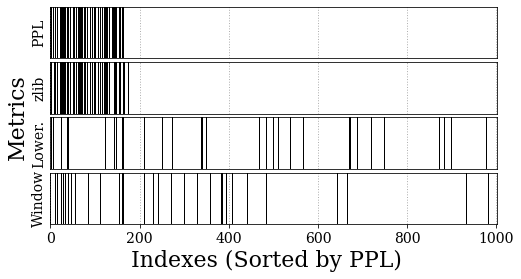

In [33]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(8, 4), facecolor="white")

widths = [12]
heights = [1, 1, 1, 1]

### 1. gridspec preparation
spec = fig.add_gridspec(
    ncols=len(widths), 
    nrows=len(heights), 
    width_ratios=widths, 
    height_ratios=heights,
    wspace=0.03, 
    hspace=0.07,
) 

axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

metric_to_label = {
    "score1_top_k": "PPL",
    "score2_top_k": "zlib",
    "score3_top_k": "Lower.",
    "score4_top_k": "Window",
}

for i, metric in enumerate(["score1_top_k", "score2_top_k", "score3_top_k", "score4_top_k"]):
    tmp = df.loc[:1000, [metric]].reset_index(drop=True).isna().T

    axs[i].pcolor(tmp, cmap="Greys_r", )

    # axs[i].spines["top"].set_visible(False)
    # axs[i].spines["bottom"].set_visible(False)
    # axs[i].yaxis.set_ticks([.5], labels=[metric_to_label[metric]], rotation=90)
    # axs[i].xaxis.set_ticks([0, 200, 400, 600, 800, 1000])
    # axs[i].xaxis.set_ticks([], minor=True)
    axs[i].tick_params(axis="both", labelsize=14, direction="out")
    axs[i].set_ylabel(metric_to_label[metric], fontsize=14)
    # axs[i].yticks(rotation=90)
    # axs[i].invert_yaxis()

    ## Grid before remove ticks.
    axs[i].grid(True, axis="x", lw=1, ls=":")

    if i == 3:
        axs[i].xaxis.set_ticks(np.arange(0, 1001, 200))
    else:
        # axs[i].yaxis.set_visible(False)
        for tick in axs[i].xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)

    for tick in axs[i].yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

## Common labels.
fig.supxlabel("Indexes (Sorted by PPL)", fontsize=22, y=-0.04)
fig.supylabel("Metrics", fontsize=22, x=.05)

# fig.tight_layout()
plt.savefig("1.pdf", dpi=300, bbox_inches="tight")
plt.show()

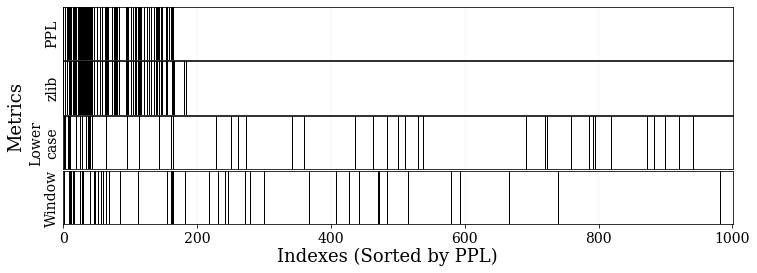

In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(12, 4), facecolor="white")

widths = [12]
heights = [1, 1, 1, 1]

### 1. gridspec preparation
spec = fig.add_gridspec(
    ncols=len(widths), 
    nrows=len(heights), 
    width_ratios=widths, 
    height_ratios=heights,
    wspace=0.03, 
    hspace=0.03,
) 

axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

metric_to_label = {
    "score1_top_k": "PPL",
    "score2_top_k": "zlib",
    "score3_top_k": "Lower\ncase",
    "score4_top_k": "Window",
}

for i, metric in enumerate(["score1_top_k", "score2_top_k", "score3_top_k", "score4_top_k"]):
    tmp = df.loc[:1000, [metric]].reset_index(drop=True).isna().T

    axs[i].pcolor(tmp, cmap="Greys_r", )

    # axs[i].spines["top"].set_visible(False)
    # axs[i].spines["bottom"].set_visible(False)
    # axs[i].yaxis.set_ticks([.5], labels=[metric_to_label[metric]], rotation=90)
    # axs[i].xaxis.set_ticks([0, 200, 400, 600, 800, 1000])
    # axs[i].xaxis.set_ticks([], minor=True)
    axs[i].tick_params(axis="both", labelsize=14, direction="out")
    axs[i].set_ylabel(metric_to_label[metric], fontsize=14)
    # axs[i].yticks(rotation=90)
    # axs[i].invert_yaxis()

    ## Grid before remove ticks.
    axs[i].grid(True, axis="x", lw=.1)

    if i == 3:
        axs[i].xaxis.set_ticks(np.arange(0, 1001, 200))
    else:
        # axs[i].yaxis.set_visible(False)
        for tick in axs[i].xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)

    for tick in axs[i].yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

## Common labels.
fig.supxlabel("Indexes (Sorted by PPL)", fontsize=18, y=-0.02)
fig.supylabel("Metrics", fontsize=18, x=.06)

# fig.tight_layout()
plt.savefig("1.pdf", dpi=300, bbox_inches="tight")
plt.show()

## **Top-1 Samples**

In [ ]:
df2

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score1_top_k_bpe,score2_top_k,score2_top_k_bpe,score3_top_k,score3_top_k_bpe,score4_top_k,score4_top_k_bpe
0,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.015625,708,1.390625,1.036133,-0.015504,45665.085257,21.268661,-0.035495,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,그의 결혼식 일요일인데 너무일찍 눈이 떠진다 했습니다. 잠을 자지 않은것처럼 머리가...,1.017578,623,1.017578,1.088867,-0.017425,35752.373113,1.000000,-0.085138,1.0,1.0,1.0,1.0,NaN,NaN,29.0,24.0
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,642,2.632812,1.036133,-0.017425,36842.734412,55.554061,-0.035495,NaN,NaN,NaN,NaN,0.0,0.0,4.0,NaN
3,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,722,1.272461,1.036133,-0.020300,35565.873842,11.869385,-0.035495,2.0,2.0,2.0,2.0,3.0,2.0,NaN,NaN
4,1. 손이 건강한 사람이 머리도 좋다. 손은 인체에서 가장 섬세한 동작과 감각을 가...,1.022461,628,1.022461,1.114258,-0.022212,28272.489734,1.000000,-0.108189,3.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,이번에 새로 산 거는요....^^; (새로 산거고 다른거고..) 아참.. 제 이름은...,4.125000,476,4.125000,1.024414,-1.417066,335.905310,1.000000,-0.024121,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
281,는것 같네요.. 그리고 이 사건이 공론화 되면서 가장 이득을 본 사람이 누구겠습니다...,4.285156,422,4.285156,1.135742,-1.455157,290.003069,1.000000,-0.127286,NaN,NaN,NaN,NaN,NaN,NaN,50.0,41.0
282,는게 더 낫지. 지금은 그냥 나만 믿고 따라와줬으면 좋겠음..ᄏᄏᄏᄏᄏᄏ 내가 더 ...,4.570312,379,4.570312,1.202148,-1.519582,249.410762,1.000000,-0.184110,NaN,NaN,NaN,NaN,NaN,NaN,80.0,70.0
283,The men's 800 metres at the 2014 European Athl...,4.593750,347,41.781250,6.878906,-1.524697,227.586250,2.447994,-1.928460,NaN,NaN,NaN,NaN,76.0,69.0,NaN,NaN


In [ ]:
df2.sort_values(by="score1_top_k", ascending=True).reset_index(drop=True).loc[0, "text"]

'1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품을 할인가격에 구입 가능합니다. 프로오더 슈프림 태극기 배색 라벨 적용 40% 할인 색상: 쵸고 / 레드오렌지 / 화이트 끈 가격: 19만원==>11만4천원 (무료배송, 주머니 포함,길들이기 서비스) 사이즈: 12.75인치 (올라운드에 적합합니다) 가죽: 국내 가공 삼양사 스틸하이드 웹: T 그물 변형웹, 일자웹 콤비배색으로 준비'

In [ ]:
df2.sort_values(by="score2_top_k", ascending=True).reset_index(drop=True).loc[0, "text"]

'1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품을 할인가격에 구입 가능합니다. 프로오더 슈프림 태극기 배색 라벨 적용 40% 할인 색상: 쵸고 / 레드오렌지 / 화이트 끈 가격: 19만원==>11만4천원 (무료배송, 주머니 포함,길들이기 서비스) 사이즈: 12.75인치 (올라운드에 적합합니다) 가죽: 국내 가공 삼양사 스틸하이드 웹: T 그물 변형웹, 일자웹 콤비배색으로 준비'

In [ ]:
df2.sort_values(by="score3_top_k", ascending=True).reset_index(drop=True).loc[0, "text"]

'1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품 20% 할인가격에 구입 가능합니다. 미즈노 MVP GXF55 FIRST BASE MITT 가격: 14만원 (무료배송) 색상: 블랙/탄 바로 길들여집니다.. 부드럽습니다 미즈노 GXC 56 CATCHER\'S MITT 가격: 14만원 (무료배송) 색상: 블랙 미국 글러브 치고는 하드합니다 미즈노 GPM1251 BASEBALL GLOVE 12", 12.'

In [ ]:
df2.sort_values(by="score4_top_k", ascending=True).reset_index(drop=True).loc[0, "text"]

'이번에 새로 산 거는요....^^; (새로 산거고 다른거고..) 아참.. 제 이름은.. 이 수환 이구요.. 나이는.. 13살이예요..^^ (나이를 너무 일찍 밝혔나요..^^?) 이 애들은.. 저희학교 5대킹카예요..^^ (제 친구들이 너무 착해요..♡) ------------------------------------ 처음 쓰는 글이라 좀 엉성한데요.. 읽어 주셔서 넘 감사해요.. 다음번에는 더 좋은 주제와 내용으로 찾아 올께요.. 그럼 안녕히.~~~♡ ------------------------------------ ──────────────────────────────────────── ※※[雪花]일본소녀 이토유리코 그녀가 한국에 떳다?!※※ 카페:http://cafe.daum.net/club8[水流花流水香]에서 퍼왔습니다. 불펌금지!! ---------------------------------'

## **Duplicated Examples**

In [ ]:
%%time
word_level_similarity = np.array([
    [calculate_similarity(i, j, is_word_level=True) for i in df2.loc[:, "text"].values]
    for j in df2.loc[:, "text"].values
])

BPE_level_similarity = np.array([
    [calculate_similarity(i, j, is_word_level=False) for i in df2.loc[:, "text"].values]
    for j in df2.loc[:, "text"].values
])

CPU times: user 5min 46s, sys: 506 ms, total: 5min 47s
Wall time: 5min 56s


In [ ]:
aa = 87
df2.loc[aa, "text"] ## hypothesis

"우리가 잘 몰랐던 事實 이곳 미국 칼리포니아에 거주하는 폴 임(Paul Lim) 박사의 저서 ('우리가 모르고 있는 모든 것이 이 책 속에 있었다.')를 참고 했으며 사진들은 별도로 자료를 수집하여 편집하였습니다 美國의 首都 워싱턴 D.C 에 高層建物이 없는 理由 워싱턴 D.C 에는 고층 건물이 없습니다. 그 이유는 국회의사당(높이 94m) 보다 더 높은 건물을 지을수 없도록 건축법이 제정돼 있기 때문입니다. 워싱턴 D.C 의 미국 국회의사당 <參考> 미국 국회의사당에는 의자가 국회의원수 보다 적게 배치가 돼 있습니다. 회의에 늦게 참석하는 의원은 뒤에 선채로 회의에 참여해야 되고 물론 명패도 없으니 화난다고 명패를 내던질 수도 없거니와 만일 기물을 내던졌다간 법의 준엄한 법의 심판을 받게 됩니다. 피카소의 그림이 루브르 博物館에 있을까? 루브르 (The Louvre) 박물관에 전시되는 작품은 그 작가가 죽은 지 60년이 지나야 전시 될 수 있습니다. 단 한사람의 예외가 있었는데 그것은"

In [ ]:
word_level_similarity[:aa, aa]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00763359, 0.        , 0.        , 0.        , 0.        ,
       0.00763359, 0.00763359, 0.        , 0.        , 0.        ,
       0.00763359, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00763359, 0.00763359, 0.        , 0.        ,
       0.        , 0.        , 0.44274809, 0.        , 0.        ,
       0.        , 0.00763359, 0.01526718, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00763359, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00763359, 0.        , 0.41984733,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00763359, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
BPE_level_similarity[:aa, aa]

array([0.        , 0.        , 0.        , 0.        , 0.00395257,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01185771, 0.        , 0.00790514, 0.        , 0.01185771,
       0.01185771, 0.01185771, 0.        , 0.        , 0.00395257,
       0.02371542, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01185771, 0.01185771, 0.        , 0.        ,
       0.        , 0.00395257, 0.54940711, 0.01185771, 0.        ,
       0.        , 0.01185771, 0.02371542, 0.        , 0.        ,
       0.        , 0.00790514, 0.        , 0.        , 0.        ,
       0.00395257, 0.01185771, 0.01185771, 0.01185771, 0.00395257,
       0.        , 0.00395257, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01976285, 0.00395257, 0.54150198,
       0.00395257, 0.        , 0.        , 0.00395257, 0.01185771,
       0.00790514, 0.01185771, 0.00395257, 0.        , 0.00790514,
       0.00395257, 0.        , 0.        , 0.00395257, 0.     

In [ ]:
df2.loc[32, "text"] ## reference

'◈ 우리가 잘 몰랐던 24가지 ◈ 1,미국의 수도 워싱턴 D.C 에 고층건물이 없는 이유 워싱턴D.C 에는 고층 건물이 없습니다. 그 이유는 국회의사당(높이 94m) 보다 더높은 건물을 지을 수 없도록 건축법이 제정돼 있기 때문입니다. 2. 미국 국회의사당에는 의자가 국회의원 수보다 적게 배치가 돼 있다. 회의에 늦게 참석하는 의원은 뒤에 선채로 회의에 참여해야 되고 물론 명패도 없으니 화난다고 명패를 내던질 수도 없거니와 만일 기물을 내던졌다간 법의 준엄한 법의 심판을 받게됩니다. 우리 나라 국회에도 적용했으면.... 3. 피카소의 그림이 루브르 박물관에 있을까? 루브르 (The Louvre) 박물관에 전시되는 작품은 그 작가가 죽은지60년이 지나야 전시될 수 있습니다. 단 한사람의 예외가 있었는데 그것은 프랑스의 화가 조오지 브라크 (George Braque1882~1963) 입니다. 4. 매미의 일생 하룻밤을 살기 위해서 매미는 17년 동안 땅속에서 번데기로 살다가 17년이 지난후 화려한 잠을 깨면 비로서 성숙된 매미로 변신되어'

In [ ]:
word_level_similarity[:59, 59]

array([0.        , 0.01428571, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01428571, 0.        , 0.        ,
       0.00714286, 0.        , 0.        , 0.        , 0.        ,
       0.02142857, 0.00714286, 0.        , 0.        , 0.        ,
       0.00714286, 0.        , 0.        , 0.00714286, 0.        ,
       0.        , 0.00714286, 0.04285714, 0.02857143, 0.        ,
       0.01428571, 0.        , 0.94285714, 0.        , 0.04285714,
       0.        , 0.00714286, 0.02142857, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02857143, 0.        ,
       0.        , 0.00714286, 0.        , 0.        , 0.        ,
       0.        , 0.01428571, 0.        , 0.        , 0.02857143,
       0.        , 0.        , 0.00714286, 0.        ])

## **Draw**

In [ ]:
def draw_it(matrix, save_name: str = None, vmin=0, vmax=1) -> None:
    plt.rcParams["font.family"] = "serif"
    fig = plt.figure(figsize=(5, 5), facecolor="white", dpi=300)

    widths = [5]
    heights = [5]

    ### 1. gridspec preparation
    spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights) #, wspace=0.03, hspace=0.03)

    axs = {}
    for i in range(len(heights)*len(widths)):
        axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

    # mask = np.tril_indices_from(matrix)
    tmp = copy.deepcopy(matrix)
    # tmp[mask] = 1

    axs[0].imshow(tmp, vmin=vmin, vmax=vmax, cmap="Greys")

    axs[0].set_xlabel("Hypothesis", fontsize=18)
    axs[0].set_ylabel("Reference", fontsize=18)
    axs[0].set_xticks([])
    axs[0].set_xticks([], minor=True)
    axs[0].set_yticks([])
    axs[0].set_yticks([], minor=True)
    axs[0].spines["top"].set_visible(True)
    axs[0].spines["bottom"].set_visible(True)
    axs[0].spines["left"].set_visible(True)
    axs[0].spines["right"].set_visible(True)

    fig.tight_layout()
    plt.savefig(f"{save_name}.pdf")

In [ ]:
idx = sorted(np.unique(
    list(df2.loc[~df2.loc[:, "score4_top_k"].isna()].index)
))
aa = np.array([[word_level_similarity[i, j] for i in idx] for j in idx])
bb = np.array([[BPE_level_similarity[i, j] for i in idx] for j in idx])

aa.shape, bb.shape

((100, 100), (100, 100))

In [ ]:
## Diff.
# draw_it(aa, save_name="2-a")
# draw_it(bb, save_name="2-b")
# draw_it(bb - aa, save_name="2-c", vmin=-1)

draw_it(np.where(aa >= 0.5, 1, 0), save_name="2-a")
draw_it(np.where(bb >= 0.5, 1, 0), save_name="2-b")
draw_it(np.where(bb >= 0.5, 1, 0) - np.where(aa >= 0.5, 1, 0), save_name="2-c", vmin=0)

try:
    from google.colab import files
    files.download("2-a.pdf")
    files.download("2-b.pdf")
    files.download("2-c.pdf")
except:
    pass

## **BPE가 Word Level보다 성능이 좋다는 것을 정량적으로 보이기**

In [ ]:
# df2.loc[~df2.loc[:, "score1_top_k"].isna(), ["score1_top_k_"]].isna().sum()

In [ ]:
## Word Level은 dup O & BPE는 dup X
for metric in ["score1_top_k", "score2_top_k", "score3_top_k", "score4_top_k"]:
    tmp = copy.deepcopy(df2).sort_values(by=metric, ascending=True).reset_index(drop=True)
    word_level_index = list(tmp.loc[~tmp.loc[:, metric].isna(), :].index)
    
    bpe_token_level_index = list(tmp.loc[~tmp.loc[:, f"{metric}_bpe"].isna(), :].index)
    bpe_token_level_index = [i for i in bpe_token_level_index if i <= max(word_level_index)]

    print(f"Word Level: {len(word_level_index)}, BPE Token Level: {len(bpe_token_level_index)}")

Word Level: 100, BPE Token Level: 94
Word Level: 100, BPE Token Level: 94
Word Level: 100, BPE Token Level: 93
Word Level: 100, BPE Token Level: 78


## **Memorized**

In [ ]:
# df = pd.read_csv("./top-k-all.csv", encoding="utf-8")
# df = df.loc[~df.loc[:, "text"].isna()]
# df = df.drop(labels=["Unnamed: 0", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25"], axis=1)
df2 = df2.sort_values(by="ppl", ascending=True).reset_index(drop=True)

assert df2.loc[~df2.loc[:, "score1_top_k"].isna()].shape[0] == 100
assert df2.loc[~df2.loc[:, "score2_top_k"].isna()].shape[0] == 100
assert df2.loc[~df2.loc[:, "score3_top_k"].isna()].shape[0] == 100
assert df2.loc[~df2.loc[:, "score4_top_k"].isna()].shape[0] == 100

df2.head()

In [ ]:
def sim(reference: list, hypothesis: list, slice_len: int = 50):
    global tokenizer

    ref_set = set(" ".join([str(j) for j in reference[i:i+slice_len]]) for i in range(len(reference)-slice_len))
    hyp_set = set(" ".join([str(j) for j in hypothesis[i:i+slice_len]]) for i in range(len(hypothesis)-slice_len))

    return len(ref_set & hyp_set) >= 1

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "kakaobrain/kogpt",
    revision="KoGPT6B-ryan1.5b-float16",
    bos_token="[BOS]",
    eos_token="[EOS]",
    unk_token="[UNK]",
    pad_token="[PAD]",
    mask_token="[MASK]",
)

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

In [ ]:
# idx =  76#@param {type:"integer"}
aa = "The 2013 UEFA European Under-17 Championship was the 17th edition of UEFA's premier youth football championship for men and women aged 17 to 23, since being held since 1959. It was originally planned for 24 teams to participate between 4 November and 29 November 2013. A total of 47 national teams were originally scheduled to play in the tournament. On 13 November 2010, the final round was played between Bulgaria and Republic of Macedonia. This second final round game was also won by Bulgaria, in addition to qualifying for the 2014 FIFA U-17 World Cup in Brazil. Group stage. On 31 May 2012, after UEFA approved the schedule of final round. The following teams participated in this stage of the competition: \"Note: In all results below, the score of the final match is given.\" Classification \"Note:\"All times in Central European Summer Time () Group A.        \u003Conlyinclude>\u003C/onlyinclude>       Group B.       \u003Conlyinclude>\u003C/onlyinclude> Group C. \u003Conlyinclude>\u003C/onlyinclude> Group D. \u003Conlyinclude>\u003C/onlyinclude> Group E. \u003Conlyinclude>"#@param {type:"string"}
bb = "\"\uADF8\uAC00 \uB098\uB97C \uB370\uB9AC\uACE0 \uC131\uC804\uC5D0 \uC774\uB974\uB7EC \uADF8 \uBB38 \uBCBD\uC744 \uCE21\uB7C9\uD558\uB2C8 \uC774\uCABD \uB450\uAED8\uB3C4 \uC5EC\uC12F \uCC99\uC774\uC694 \uC800\uCABD \uB450\uAED8\uB3C4 \uC5EC\uC12F \uCC99\uC774\uB77C \uB450\uAED8\uAC00 \uADF8\uC640 \uAC19\uC73C\uBA70 \uADF8 \uBB38 \uD1B5\uB85C\uC758 \uB108\uBE44\uB294 \uC5F4 \uCC99\uC774\uC694 \uBB38 \uD1B5\uB85C \uC774\uCABD \uBCBD\uC758 \uB108\uBE44\uB294 \uB2E4\uC12F \uCC99\uC774\uC694 \uC800\uCABD \uBCBD\uC758 \uB108\uBE44\uB294 \uB2E4\uC12F \uCC99\uC774\uBA70 \uADF8\uAC00 \uC131\uC18C\uB97C \uCE21\uB7C9\uD558\uB2C8 \uADF8 \uAE38\uC774\uB294 \uB9C8\uD754 \uCC99\uC774\uC694 \uADF8 \uB108\uBE44\uB294 \uC2A4\uBB34 \uCC99\uC774\uBA70 \uADF8\uAC00 \uC548\uC73C\uB85C \uB4E4\uC5B4\uAC00\uC11C \uB0B4\uC804 \uBB38\uD1B5\uB85C\uC758 \uBCBD\uC744 \uCE21\uB7C9\uD558\uB2C8 \uB450\uAED8\uB294 \uB450 \uCC99\uC774\uC694 \uBB38\uD1B5\uB85C\uAC00 \uC5EC\uC12F \uCC99\uC774\uC694 \uBB38\uD1B5\uB85C\uC758 \uBCBD\uC758 \uB108\uBE44\uB294 \uAC01\uAE30 \uC77C\uACF1 \uCC99\uC774\uBA70 \uADF8\uAC00 \uB0B4\uC804\uC744 \uCE21\uB7C9\uD558\uB2C8 \uAE38\uC774\uB294 \uC2A4\uBB34 \uCC99\uC774\uC694 \uB108\uBE44\uB294 \uC2A4\uBB34 \uCC99\uC774\uB77C \uADF8\uAC00 \uB0B4\uAC8C \uC774\uB974\uB418 \uC774\uB294 \uC9C0\uC131\uC18C\uB2C8\uB77C \uD558\uACE0 \uC131\uC804\uC758 \uBCBD\uC744 \uCE21\uB7C9\uD558\uB2C8 \uB450\uAED8\uAC00 \uC5EC\uC12F \uCC99\uC774\uBA70 \uC131\uC804 \uC0BC\uBA74\uC5D0 \uACE8\uBC29\uC774 \uC788\uB294\uB370 \uB108\uBE44\uB294 \uAC01\uAE30 \uB124 \uCC99\uC774\uBA70 \uACE8\uBC29\uC740 \uC0BC \uCE35\uC778\uB370 \uACE8\uBC29 \uC704\uC5D0 \uACE8\uBC29\uC774 \uC788\uC5B4 \uBAA8\uB450 \uC11C\uB978\uC774\uB77C \uADF8 \uC0BC\uBA74 \uACE8\uBC29\uC774 \uC131\uC804 \uBCBD \uBC16\uC73C\uB85C \uADF8 \uBCBD\uC5D0 \uBD99\uC5B4 \uC788\uB294\uB370 \uC131\uC804 \uBCBD \uC18D\uC744 \uB6AB\uC9C0\uB294 \uC544\uB2C8\uD558\uC600\uC73C\uBA70 \uC774 \uB450\uB8E8 \uC788\uB294 \uACE8\uBC29\uC740 \uADF8 \uCE35\uC774 \uB192\uC544 \uC9C8\uC218\uB85D \uB113\uC73C\uBBC0\uB85C \uC131\uC804\uC5D0 \uB458\uB9B0 \uC774 \uACE8\uBC29\uC774 \uB192\uC544 \uC9C8\uC218\uB85D \uC131\uC804\uC5D0 \uAC00\uAE4C\uC6CC\uC84C\uC73C\uB098 \uC131\uC804\uC758 \uB113\uC774\uB294 \uC544\uB798 \uC704\uAC00 \uAC19\uC73C\uBA70 \uACE8\uBC29\uC740 \uC544\uB798 \uCE35\uC5D0\uC11C" #@param {type:"string"}

aa = np.array(tokenizer.encode(aa))
bb = np.array(tokenizer.encode(bb))

# print(sim(aa, bb))
aa

## **Results**

In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/mia/top-k-all.csv ./top-k-all.csv

In [ ]:
df = pd.read_csv("./top-k-all.csv", encoding="utf-8")
df = df.loc[~df.loc[:, "text"].isna()]
# df = df.drop(labels=["Unnamed: 0", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25"], axis=1)
df = df.drop(labels=["Unnamed: 0"], axis=1)
df = df.sort_values(by="ppl", ascending=True).reset_index(drop=True)

assert df.loc[~df.loc[:, "score1_top_k"].isna()].shape[0] == 100
assert df.loc[~df.loc[:, "score2_top_k"].isna()].shape[0] == 100
assert df.loc[~df.loc[:, "score3_top_k"].isna()].shape[0] == 100
assert df.loc[~df.loc[:, "score4_top_k"].isna()].shape[0] == 100

assert df.loc[~df.loc[:, "score1_top_k"].isna(), "memorized"].isna().sum().sum() == 0
assert df.loc[~df.loc[:, "score2_top_k"].isna(), "memorized"].isna().sum().sum() == 0
assert df.loc[~df.loc[:, "score3_top_k"].isna(), "memorized"].isna().sum().sum() == 0
assert df.loc[~df.loc[:, "score4_top_k"].isna(), "memorized"].isna().sum().sum() == 0

df.head()

In [ ]:
aa = df.loc[~df.loc[:, "score1_top_k"].isna(), "memorized"].values
len(np.where(aa == True)[0]), len(np.where(aa == False)[0])

(89, 11)

In [ ]:
aa = df.loc[~df.loc[:, "score2_top_k"].isna(), "memorized"].values
len(np.where(aa == True)[0]), len(np.where(aa == False)[0])

(90, 10)

In [ ]:
aa = df.loc[~df.loc[:, "score3_top_k"].isna(), "memorized"].values
len(np.where(aa == True)[0]), len(np.where(aa == False)[0])

(20, 80)

In [ ]:
aa = df.loc[~df.loc[:, "score4_top_k"].isna(), "memorized"].values
len(np.where(aa == True)[0]), len(np.where(aa == False)[0])

(52, 48)

In [ ]:
# df = df.loc[df.loc[:, "text"].map(lambda x: "안녕하세요.~ 제주 토배기 제주바다(제주조수수산)입니다.~~ 오늘도 저희 생선 드시고 건강한 하루되세요.~^^ 그럼, 오늘도 판매시작합니다.~^^ (택배비 별도, 계좌는 맨 하단 참조바랍니다.)" in x)]
# df = df.reset_index(drop=True)
# df

In [ ]:
aa = tokenizer.encode(df.loc[0, "text"])
bb = tokenizer.encode("안녕하세요.~ 제주 토배기 제주바다(제주조수수산)입니다.~~ 오늘도 저희 생선 드시고 건강한 하루되세요.~^^ 그럼, 오늘도 판매시작합니다.~^^ (택배비 별도, 계좌는 맨 하단 참조바랍니다.)")

sim(aa, bb)

True

In [ ]:
df = df.drop_duplicates(subset=["text"]).sort_values(by="score2", ascending=False).reset_index(drop=True)
# df = df.loc[:, ["text", "score2", "score2_top_k"]]
df

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score2_top_k,score3_top_k,score4_top_k
0,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,NaN,NaN,NaN,True
1,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만지...,1.080078,791,1.132812,1.375000,-1.080078,732.354430,1.048825,-1.375000,NaN,NaN,NaN,NaN
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,746,1.463867,1.036133,-1.020508,731.008612,1.434450,-1.036133,NaN,True,NaN,NaN
3,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만지...,1.083984,782,1.138672,1.355469,-1.083984,721.412613,1.050450,-1.355469,NaN,NaN,NaN,NaN
4,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.019531,729,1.267578,1.036133,-1.019531,715.034483,1.243295,-1.036133,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99966,안녕들 하십니까!.??. ^_^.!!. - -^-^.. - _ -......- - ...,6.839844,174,6.839844,4.085938,-6.839844,25.439178,1.000000,-4.085938,NaN,NaN,NaN,NaN
99967,These are the official results of the Women's ...,14.156250,358,206.000000,6.101562,-14.156250,25.289183,14.551876,-6.101562,NaN,NaN,True,NaN
99968,"1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.164062,25,1.164062,1.387695,-1.164062,21.476510,1.000000,-1.387695,NaN,NaN,NaN,NaN
99969,<<<<<<<<<<<<<<<>>> <<<<<<<<<<<<<<<>>>>>>>>>>>>...,1.404297,27,1.404297,1.232422,-1.404297,19.226704,1.000000,-1.232422,NaN,NaN,NaN,NaN


In [ ]:
df = deduplicate(df)
df

Deduplicating: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


,text,score2,score2_top_k,score2_top_k_
0,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,True,True
1,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만지...,732.354430,-,-
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,731.008612,True,True
3,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만지...,721.412613,-,-
4,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,715.034483,True,True
...,...,...,...,...
99966,안녕들 하십니까!.??. ^_^.!!. - -^-^.. - _ -......- - ...,25.439178,-,-
99967,These are the official results of the Women's ...,25.289183,-,-
99968,"1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",21.476510,-,-
99969,<<<<<<<<<<<<<<<>>> <<<<<<<<<<<<<<<>>>>>>>>>>>>...,19.226704,-,-


In [ ]:
idx1 = df.loc[df.loc[:, "score2_top_k"] == True].index
idx2 = df.loc[df.loc[:, "score2_top_k_"] == True].index

df = df.loc[:max(max(idx1), max(idx2))].reset_index(drop=True)
df.to_csv("1.csv", encoding="utf-8")

In [ ]:
%%time
word_level_similarity = np.array([
    [calculate_similarity(i, j, is_word_level=True) for i in df.loc[:, "text"].values]
    for j in df.loc[:, "text"].values
])

BPE_level_similarity = np.array([
    [calculate_similarity(i, j, is_word_level=False) for i in df.loc[:, "text"].values]
    for j in df.loc[:, "text"].values
])

CPU times: user 2min 39s, sys: 313 ms, total: 2min 40s
Wall time: 2min 53s


In [ ]:
def draw_it(matrix, save_name: str = None, vmin=0, vmax=1) -> None:
    plt.rcParams["font.family"] = "serif"
    fig = plt.figure(figsize=(5, 5), facecolor="white", dpi=300)

    widths = [5]
    heights = [5]

    ### 1. gridspec preparation
    spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights) #, wspace=0.03, hspace=0.03)

    axs = {}
    for i in range(len(heights)*len(widths)):
        axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

    # mask = np.tril_indices_from(matrix)
    tmp = copy.deepcopy(matrix)
    # tmp[mask] = 1

    axs[0].imshow(tmp, vmin=vmin, vmax=vmax)

    axs[0].set_xlabel("Hypothesis", fontsize=18)
    axs[0].set_ylabel("Reference", fontsize=18)
    axs[0].set_xticks([])
    axs[0].set_xticks([], minor=True)
    axs[0].set_yticks([])
    axs[0].set_yticks([], minor=True)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["left"].set_visible(False)
    axs[0].spines["right"].set_visible(False)

    fig.tight_layout()
    plt.savefig(f"{save_name}.pdf")

In [ ]:
## Diff.
draw_it(word_level_similarity, save_name="2-a")
draw_it(BPE_level_similarity, save_name="2-b")
draw_it(BPE_level_similarity - word_level_similarity, save_name="2-c", vmin=-1)

draw_it(np.where(word_level_similarity >= 0.5, 1, 0), save_name="2-d")
draw_it(np.where(BPE_level_similarity >= 0.5, 1, 0), save_name="2-e")
draw_it(np.where(BPE_level_similarity >= 0.5, 1, 0) - np.where(word_level_similarity >= 0.5, 1, 0), save_name="2-f", vmin=-1)

In [ ]:
try:
    from google.colab import files
    files.download("2-a.pdf")
    files.download("2-b.pdf")
    files.download("2-c.pdf")
    files.download("2-d.pdf")
    files.download("2-e.pdf")
    files.download("2-f.pdf")
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df2 = pd.read_csv(args.kakao.path, encoding="utf-8")
df2 = df2.drop_duplicates(subset=["text"]).sort_values(by="score1", ascending=False).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
metric = "score4"

df2.loc[df2.loc[:, f"{metric}_top_k"] == True].sort_values(by=metric, ascending=False)

,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score2_top_k,score3_top_k,score4_top_k
4753,"지난 21일 방송된 SBS 월화드라마 '복수가 돌아왔다' 6, 7회에서 곽동연은 학...",3.128906,573,3.244141,1.024414,-3.128906,183.131086,1.036829,-1.024414,NaN,NaN,NaN,True
288,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.304688,665,1.784180,1.036133,-1.304688,509.700599,1.367515,-1.036133,NaN,NaN,NaN,True
973,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,2.169922,583,2.763672,1.036133,-2.169922,268.673267,1.273627,-1.036133,NaN,NaN,NaN,True
524,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.690430,684,2.669922,1.036133,-1.690430,404.630849,1.579434,-1.036133,NaN,NaN,NaN,True
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,646,2.591797,1.036133,-1.017578,634.840691,2.547025,-1.036133,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,오늘(13일) 새벽 3시 10분쯤 경기 파주시 법원읍의 한 자동차 정비소에서 불이 ...,1.956055,722,2.564453,1.221680,-1.956055,369.110334,1.311033,-1.221680,NaN,NaN,NaN,True
12782,"[이데일리N] 1. 文 ""올해 한국경제 2%대 성장 가능, 반등의 모멘텀 마련"" 2...",3.833984,798,7.941406,1.221680,-3.833984,208.138563,2.071319,-1.221680,NaN,NaN,NaN,True
41,1. 당신은 아는가? 사람은 평생동안 잘 때 200여마리의 벌레와 100여마리의 미...,1.046875,591,1.046875,1.221680,-1.046875,564.537313,1.000000,-1.221680,True,True,NaN,True
527,성탄예배 - 성탄의 뿌리를 찾아서 마 1:18-25 예수 그리스도의 나심은 이러하니...,1.692383,687,1.692383,1.222656,-1.692383,405.936526,1.000000,-1.222656,NaN,NaN,NaN,True


In [ ]:
df2.loc[df2.loc[:, f"{metric}_top_k"] == True].sort_values(by=metric, ascending=False).reset_index(drop=True).loc[0, "text"]

"지난 21일 방송된 SBS 월화드라마 '복수가 돌아왔다' 6, 7회에서 곽동연은 학교 폭력 가해자로 몰려 고발 된 후 누명을 벗기 위해 강복수(유승호 분)에게 손을 내미는가 하면 이후 전교회장 선거로 인해 학교에 남게 되면서 새로운 국면에 접어들었다. 한편 학교폭력 피해의 사실을 알게 된 강복수(유승호 분)의 과거 트라우마가 드러나 앞으로 어떤 전개가 펼쳐질지 귀추가 주목되는 가운데, 곽동연과 유승호의 '학교폭력 피해자와 가해자'를 오가는 극과 극 분위기를 드러내는가 하며 '복수바라기' 유승호에게 의문의 택배가 도착해 어떤 이야기가 펼쳐질지 궁금증을 자아내고 있다. '복수가 돌아왔다'는 매주 월, 화요일 오후 10시에 방송된다. mkculture@mkculture.com [c 매일경제 & mk.co.kr, 무단전재 및 재배포 금지] ───────────────────────────────"

In [ ]:
aa = df.loc[:, "ppl"].values
bb = df.loc[:, "zlib_entropy"].values

metric = bb / np.log(aa)
df.loc[:, "score1_"] = metric

In [ ]:
metric = "score1_"
df.sort_values(by=metric, ascending=False).reset_index(drop=True).loc[:100]


,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score2_top_k,score3_top_k,score4_top_k,score3_,score1_
0,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.015625,721,1.382812,1.036133,-1.015625,709.907692,1.361538,-1.036133,NaN,NaN,NaN,NaN,20.905287,46503.568461
1,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.019531,729,1.267578,1.036133,-1.019531,715.034483,1.243295,-1.036133,NaN,NaN,NaN,NaN,12.258106,37688.124922
2,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.017578,646,2.591797,1.036133,-1.017578,634.840691,2.547025,-1.036133,NaN,NaN,NaN,True,54.653006,37072.284159
3,1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...,1.020508,746,1.463867,1.036133,-1.020508,731.008612,1.434450,-1.036133,NaN,True,NaN,NaN,18.772165,36748.118955
4,그의 결혼식 일요일인데 너무일찍 눈이 떠진다 했습니다. 잠을 자지 않은것처럼 머리가...,1.017578,637,1.017578,1.088867,-1.017578,625.996161,1.000000,-1.088867,NaN,True,NaN,True,1.000000,36555.797228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,◐ 새 한글 맞춤법 표준어 일람표. ◑ ◈ 새 한글 맞춤법 표준어 일람표 ◈ <ᄀ>...,1.059570,536,1.059570,1.350586,-1.059570,505.865438,1.000000,-1.350586,NaN,NaN,NaN,NaN,1.000000,9263.186068
97,서울대학교 합격자 생활수기 공모에서 고른 글 실밥이 뜯어진 운동화 지퍼가 고장난 검...,1.081055,718,1.081055,1.289062,-1.081055,664.166215,1.000000,-1.289062,True,True,NaN,NaN,1.000000,9212.554101
98,1월 1일: 스노드롭: 희망 2일: 노랑수선화: 사랑에 답하여 3일: 사프란(Spr...,1.059570,529,1.344727,1.320312,-1.059570,499.258986,1.269124,-1.320312,True,NaN,NaN,NaN,5.118786,9142.211623
99,◈ 가훈으로 적절한 문구모음 ◈ 博愛 (박애) 널리 사랑하라 中庸 (중용) 치우치지...,1.074219,654,1.074219,1.369141,-1.074219,608.814545,1.000000,-1.369141,True,True,NaN,NaN,1.000000,9134.887953


In [ ]:
aa = df.loc[:, "ppl_lower"].values
bb = df.loc[:, "ppl"].values

metric = np.log(aa) / np.log(bb)
df.loc[:, "score3_"] = metric

In [ ]:
metric = "score3_"
# df.sort_values(by="score3_", ascending=False).reset_index(drop=True).loc[:100].to_csv("score3.csv", encoding="utf-8")
df.sort_values(by="score3_", ascending=False).reset_index(drop=True).loc[0, "text"]

'1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품 20% 할인가격에 구입 가능합니다. 미즈노 MVP GXF55 FIRST BASE MITT 가격: 14만원 (무료배송) 색상: 블랙/탄 바로 길들여집니다.. 부드럽습니다 미즈노 GXC 56 CATCHER\'S MITT 가격: 14만원 (무료배송) 색상: 블랙 미국 글러브 치고는 하드합니다 미즈노 GPM1251 BASEBALL GLOVE 12", 12.5" 가격:'

In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(3, 10), facecolor="white")

widths = [1]
heights = [1]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights) #, wspace=0.03, hspace=0.03)

axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

axs[0].imshow(np.tile(aa[:, np.newaxis], (1, 10000)), cmap="gray_r")
axs[0].set_xticks([])
axs[0].set_xticks([], minor=True)
axs[0].set_yscale("log")

# axs[0].set_yticks([])
# axs[0].set_yticks([], minor=True)

fig.tight_layout()
plt.show()

In [ ]:
aa = np.where((df2.loc[:, "score1_top_k"] == True).values, 1, 0)
aa

array([0, 0, 0, ..., 0, 0, 0])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


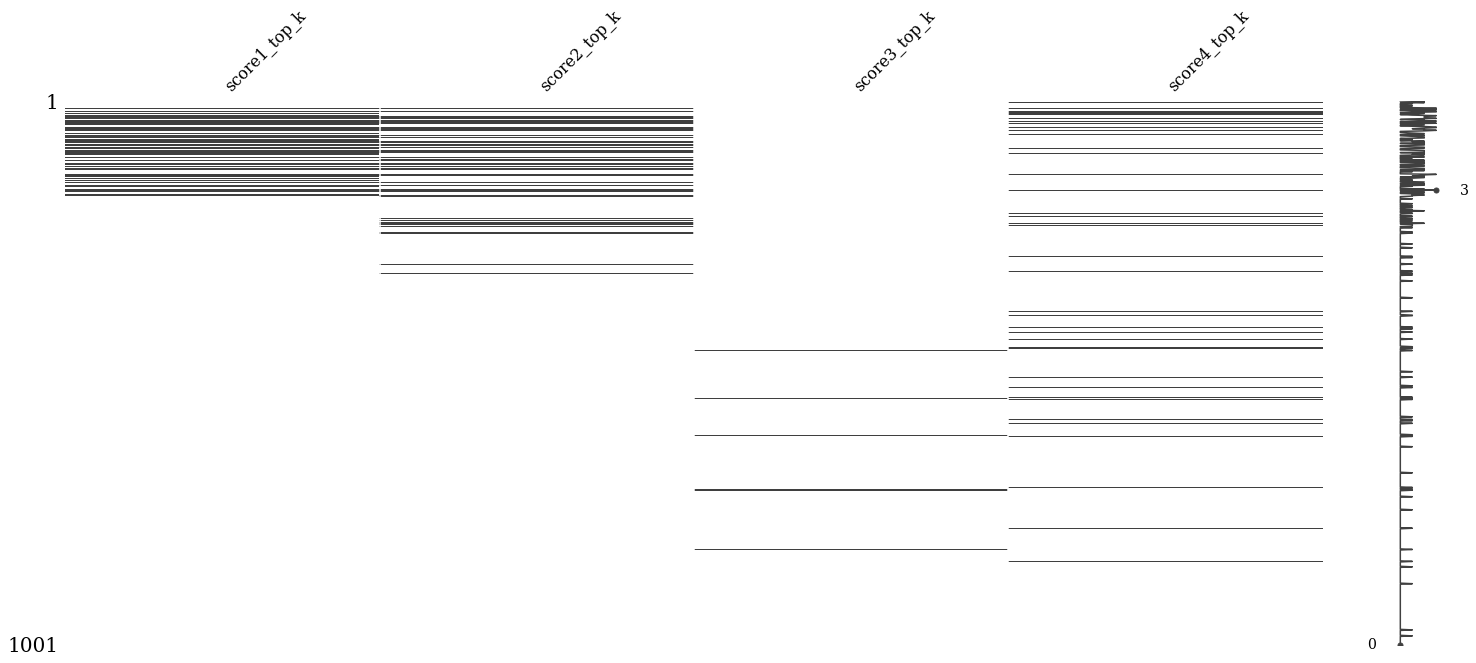

In [ ]:
df2 = pd.read_csv(args.kakao.path, encoding="utf-8")
df2 = df2.drop_duplicates(subset=["text"]).sort_values(by="score1", ascending=False).reset_index(drop=True)

missingno.matrix(df2.loc[:1000, ["score1_top_k", "score2_top_k", "score3_top_k", "score4_top_k"]])
# df2.head()

# idx1 = df2.loc[df2.loc[:, "score1_top_k"] == True].index
# idx2 = df2.loc[df2.loc[:, "score2_top_k"] == True].index
# idx3 = df2.loc[df2.loc[:, "score3_top_k"] == True].index
# idx4 = df2.loc[df2.loc[:, "score4_top_k"] == True].index

# idx = list(idx1) + list(idx2) + list(idx3) + list(idx4)
# max_idx = max(idx)

# max_idx

In [ ]:
df2

In [ ]:
# Program to visualize missing values in dataset

# Importing the libraries
import pandas as pd

# Loading the dataset

# Visualize missing values as a matrix
msno.matrix(df)

In [ ]:
aa = np.where(BPE_level_similarity >= 0.5, 1, 0) - np.where(word_level_similarity >= 0.5, 1, 0)
np.min(aa), np.max(aa)

(0, 1)

In [ ]:
idx = 20

word_level_similarity[idx, :idx], BPE_level_similarity[idx, :idx]

(array([0.        , 0.        , 0.46666667, 0.        , 0.42424242,
        0.66129032, 0.        , 0.        , 0.96923077, 0.        ,
        0.        , 0.        , 0.256     , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.55642023, 0.        , 0.46303502,
        0.67315175, 0.        , 0.        , 0.9844358 , 0.        ,
        0.        , 0.        , 0.38910506, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))

In [ ]:
df.loc[idx]

text             1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...
score2                                                  682.666667
score2_top_k                                                     -
score2_top_k_                                                 True
Name: 20, dtype: object

In [ ]:
idx = 36

tmp.loc[np.where(word_level_similarity[idx, :idx+1] >= 0.5), "text"].values

array(['1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품을 할인가격에 구입 가능합니다. 프로오더 슈프림 태극기 배색 라벨 적용 40% 할인 색상: 쵸고 / 레드오렌지 / 화이트 끈 가격: 19만원==>11만4천원 (무료배송, 주머니 포함,길들이기 서비스) 사이즈: 12.75인치 (올라운드에 적합합니다) 가죽: 국내 가공 삼양사 스틸하이드 웹: T 그물 변형웹, 일자웹 콤비배색으로 준비하여 느낌이 좋',
       '1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품을 할인가격에 구입 가능합니다. 프로오더 슈프림 태극기 배색 라벨 적용 40% 할인 색상: 쵸고 / 레드오렌지 / 화이트 끈 가격: 19만원==>11만4천원 

In [ ]:
np.where((BPE_level_similarity >= 0.5) & (word_level_similarity < 0.5))

(array([  6,   6,   6,   6,   7,  12,  12,  13,  13,  14,  14,  15,  15,
         16,  16,  19,  20,  25,  25,  36,  37,  38,  41,  41,  47,  47,
         48,  48,  48,  48,  48,  48,  79,  80,  81,  82,  86,  87,  93,
         99, 105, 105, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
        121, 121, 121, 134, 134, 142, 142, 142, 142, 142, 142, 142, 142,
        142, 142, 142, 142, 144, 156, 172, 172, 172, 175, 185, 185, 190,
        190]),
 array([ 36,  37,  38, 185,  66,   6, 142,   6, 142,   6, 142,   6, 142,
          6, 142,   6,   6, 121, 142,   6,   6,   6, 121, 142,   6, 142,
          0,   1,   2,   3,   4,  66,   6,   6,   6, 172,   6, 190, 190,
          6, 127, 172,  12,  13,  14,  15,  16,  47,  79,  80,  81,  86,
         99, 144, 185, 156, 189,  12,  13,  14,  15,  16,  47,  79,  80,
         81,  86, 144, 185,   6,   6,  82, 105, 175, 172,   6, 142,  87,
         93]))

In [ ]:
aa = np.where(BPE_level_similarity >= 0.5, 1, 0) - np.where(word_level_similarity >= 0.5, 1, 0)

mask = np.tril_indices_from(aa)
aa[mask] = 0

np.where(aa==1)

(array([  6,   6,   6,   6,   7,  12,  13,  14,  15,  16,  25,  25,  41,
         41,  47,  48,  82,  87,  93, 105, 105, 121, 121, 134, 134, 142,
        142, 172]),
 array([ 36,  37,  38, 185,  66, 142, 142, 142, 142, 142, 121, 142, 121,
        142, 142,  66, 172, 190, 190, 127, 172, 144, 185, 156, 189, 144,
        185, 175]))

In [ ]:
df.loc[[6, 12, 20], "text"].values

array(['1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서 신용카드 및 기성품 20% 할인가격에 구입하세요 아울러 오더 글러브 3주 완성 이벤트 진행을 합니다^^ 프로젝트 夏成 글러브 판매합니다^^ 세인트볼파크!, AFB, 35년 역사의 공장 생산 한정 수량입니다. 공통사항: 일본산 프리미엄 스틸하이드 적용(연 오렌지는 킵) 일본산 끈피 적용(검정 단면끈의 경우 국내 최고등급 끈 적용) 양모 보아 적용 프로선수들과 일본 선수들이 선호하는 사이즈인 12.75인치 적용 2010년 클리어랜스 세일 하성 글러브 개당 25만원 동일가격 판매 (킵, 스틸하이드 구분 없',
       '1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처: 816-0816, 010-8981-0816 4. 판매지역: 부산 세인트볼파크 매장 및 전국 택배 5. 판매금액: 아래에 표기하겠습니다 6. 부가설명: 기성품 및 미스오더에 한해 할인 판매를 합니다. 세볼팍 글러브구입시 글러브 주머니 서비스 & 무료배송 7. 계좌번호: 외환은행 ***-**-*****-* 성태호입니다 타 계좌로 송금하시는 경우 세인트볼파크에서 책임 지지 않습니다^^ 세인트볼파크 매장에서 할인가로 글러브 구입하세요. 매장을 방문하시는분께 특가로 드립니다^^ 세인트볼파크 홈페이지 sbp21.co.kr 에서도 신용카드 및 기성품을 할인가격에 구입 가능합니다. 프로오더 슈프림 태극기 배색 라벨 적용 40% 할인 색상: 쵸고 / 레드오렌지

In [ ]:
word_level_similarity[20, 6]

0.4888888888888889

Deduplicating: 100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


,text,ppl,zlib_entropy,ppl_lower,sliding_window,score1,score2,score3,score4,score1_top_k,score2_top_k,score3_top_k,score4_top_k,score2_top_k_
0,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,True,NaN,NaN,NaN,True
1,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,NaN,NaN,NaN,NaN,
2,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,NaN,True,NaN,NaN,
3,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,NaN,NaN,NaN,NaN,
4,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,1.056641,792,1.106445,1.220703,-1.056641,749.545287,1.047135,-1.220703,NaN,NaN,NaN,True,


,text,score2,score2_top_k,score2_top_k_
0,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,,True
1,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,,
2,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,True,
3,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,,
4,◈ 놀라운 자연의 신비 ◈ 자연이 보여주는 아름다움과 기이한 모습에 한없이 작아만 ...,749.545287,,
...,...,...,...,...
99995,안녕들 하십니까!.??. ^_^.!!. - -^-^.. - _ -......- - ...,25.439178,,
99996,These are the official results of the Women's ...,25.289183,,
99997,"1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",21.476510,,
99998,<<<<<<<<<<<<<<<>>> <<<<<<<<<<<<<<<>>>>>>>>>>>>...,19.226704,,


In [ ]:
idx = 36

In [ ]:
df.loc[idx]

text              1. 제품명: SaintBall Park 2. 제품상태: NEW 3. 판매자연락처:...
ppl                                                         1.03418
zlib_entropy                                                    706
ppl_lower                                                  1.416016
sliding_window                                             1.036133
score1                                                     -1.03418
score2                                                   682.666667
score3                                                     1.369216
score4                                                    -1.036133
score1_top_k                                                    NaN
score2_top_k                                                    NaN
score3_top_k                                                    NaN
score4_top_k                                                    NaN
score2_top_k_                                                  True
Name: 36, dtype: object

In [ ]:
word_level_similarity[idx, :idx]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.46666667, 0.        , 0.42424242, 0.42424242,
       0.42424242, 0.42424242, 0.66129032, 0.66129032, 0.66129032,
       0.66129032, 0.66129032, 0.        , 0.        , 0.96923077,
       0.96923077, 0.        , 0.        , 0.        , 0.        ,
       0.256     , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [ ]:
BPE_level_similarity[idx, :idx]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.55642023, 0.        , 0.46303502, 0.46303502,
       0.46303502, 0.46303502, 0.67315175, 0.67315175, 0.67315175,
       0.67315175, 0.67315175, 0.        , 0.        , 0.9844358 ,
       0.9844358 , 0.        , 0.        , 0.        , 0.        ,
       0.38910506, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [ ]:
word_level_similarity[0]

In [ ]:
np.triu_indices_from(word_level_similarity)

(array([  0,   0,   0, ..., 206, 206, 207]),
 array([  0,   1,   2, ..., 206, 207, 207]))

In [ ]:
mask[np.triu_indices_from(mask)]

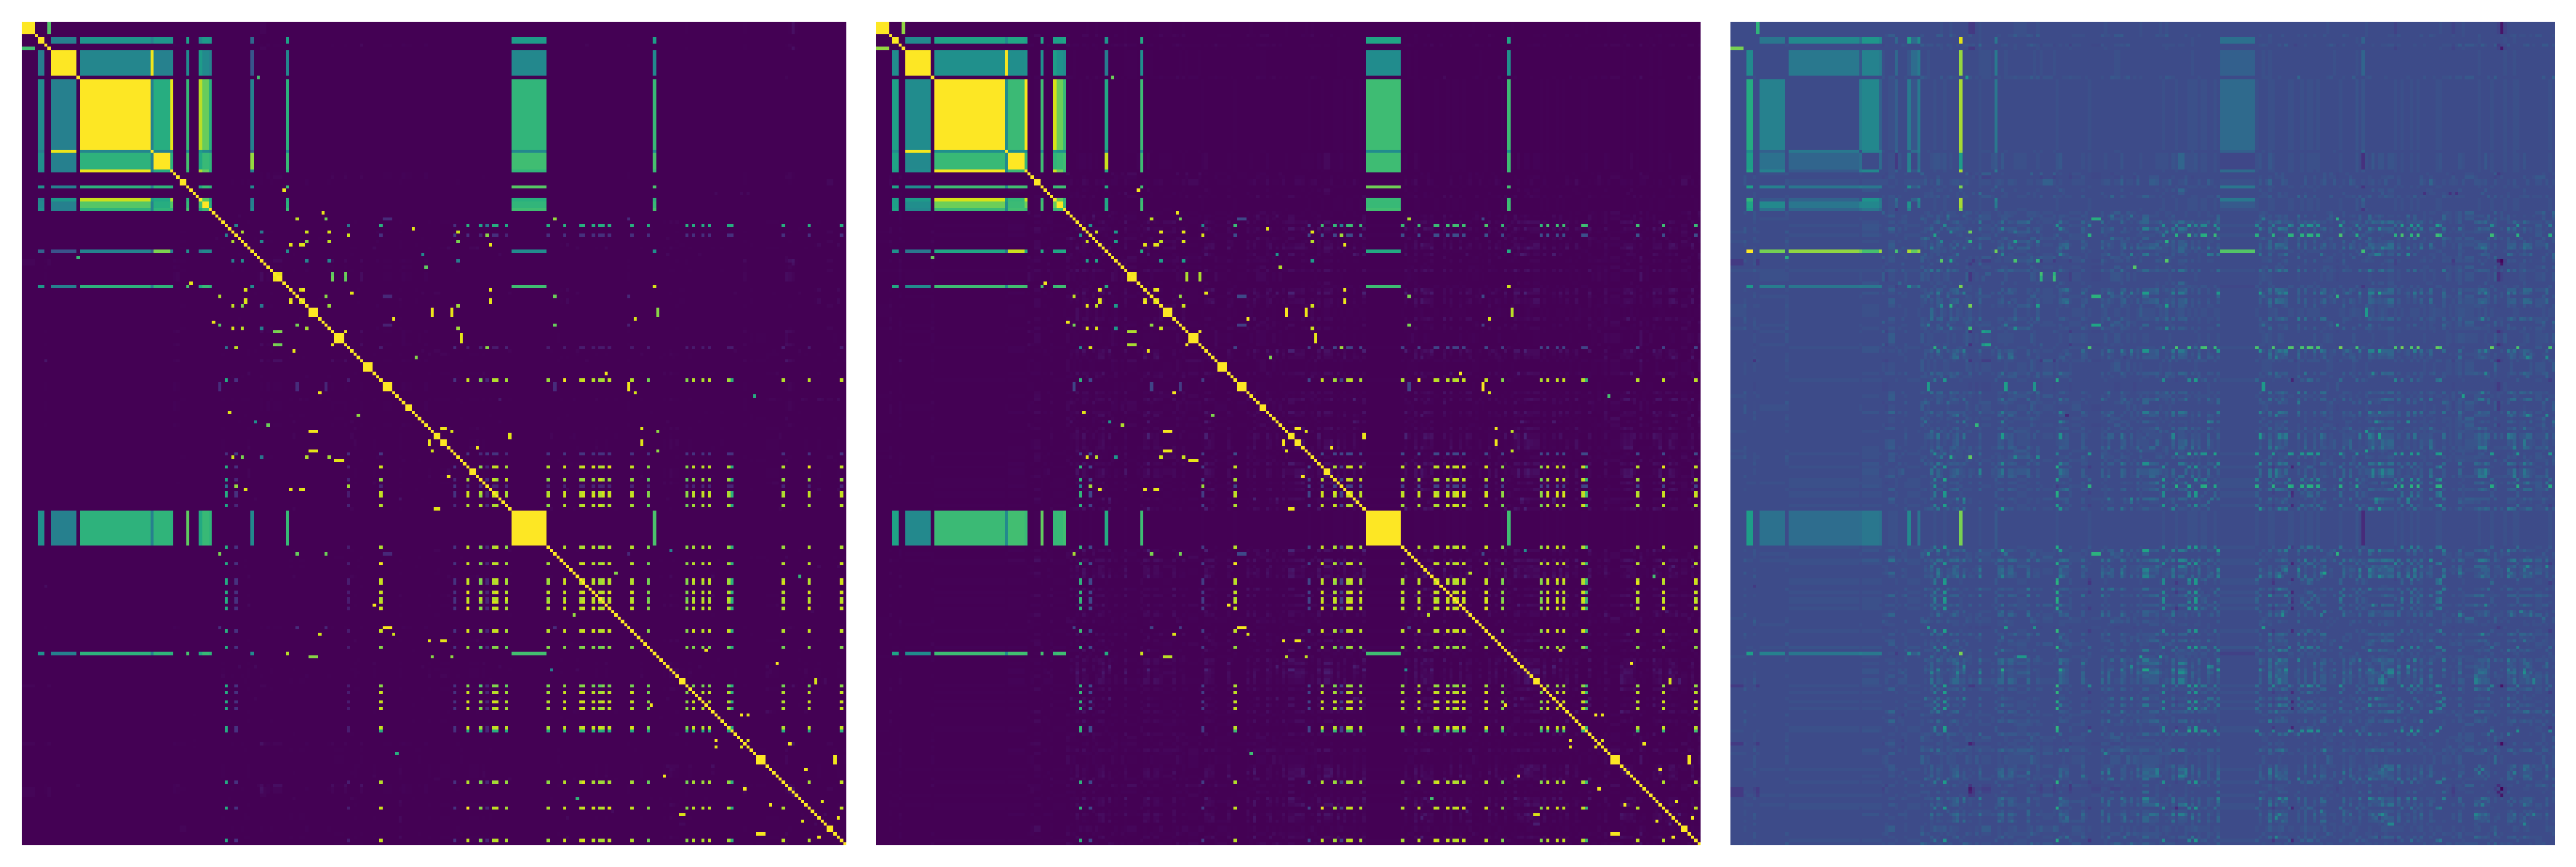

In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(15, 5), facecolor="white", dpi=300)

widths = [5, 5, 5]
heights = [5]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights,
                        wspace=0.03, hspace=0.03)

### 2. setting axes
axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])
    # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment": "center", "color": "gray"})

mask = np.zeros_like(word_level_similarity, dtype=bool)
mask[np.triu_indices_from(mask)] = True

## Plot 1.
# sns.heatmap(word_level_similarity, ax=axs[0], vmin=0, vmax=1, center=0.5, cmap="Blues", mask=mask, square=True)
axs[0].imshow(word_level_similarity)

# axs[0].set_xlabel("Reference", fontsize=12)
# axs[0].set_ylabel("Hypothesis", fontsize=12)
axs[0].set_xticks([])
axs[0].set_xticks([], minor=True)
axs[0].set_yticks([])
axs[0].set_yticks([], minor=True)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].spines["right"].set_visible(False)

## Plot 2.
# sns.heatmap(BPE_level_similarity, ax=axs[1], vmin=0, vmax=1, center=0.5, cmap="Blues", mask=mask, square=True)
axs[1].imshow(BPE_level_similarity)

# axs[1].set_xlabel("Reference", fontsize=12)
# axs[1].set_ylabel("Hypothesis", fontsize=12)
axs[1].set_xticks([])
axs[1].set_xticks([], minor=True)
axs[1].set_yticks([])
axs[1].set_yticks([], minor=True)
axs[1].spines["top"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].spines["right"].set_visible(False)

## Plot 3: diff.
# sns.heatmap(BPE_level_similarity, ax=axs[1], vmin=0, vmax=1, center=0.5, cmap="Blues", mask=mask, square=True)
axs[2].imshow(BPE_level_similarity - word_level_similarity)

# axs[2].set_xlabel("Reference", fontsize=12)
# axs[2].set_ylabel("Hypothesis", fontsize=12)
axs[2].set_xticks([])
axs[2].set_xticks([], minor=True)
axs[2].set_yticks([])
axs[2].set_yticks([], minor=True)
axs[2].spines["top"].set_visible(False)
axs[2].spines["bottom"].set_visible(False)
axs[2].spines["left"].set_visible(False)
axs[2].spines["right"].set_visible(False)

# fig.tight_layout()
plt.show()

In [ ]:
np.mean(word_level_similarity), np.mean(BPE_level_similarity)

(0.05021939705510044, 0.055196588689630684)

In [ ]:
len(np.where(word_level_similarity > 0.5)[0])

3420

In [ ]:
len(np.where(BPE_level_similarity > 0.5)[0])

3855

In [ ]:
axs[0].grid(True, lw=.1)
axs[0].tick_params(axis="both", direction="in")
axs[0].set_xlabel("Scores", fontsize=18)
axs[0].set_ylabel("Density", fontsize=18)
axs[0].tick_params(axis="both", labelsize=12)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
# axs[0].legend(loc="lower right", fontsize=14)
axs[0].set_xlim([-5, 290])
axs[0].set_ylim([0, 0.021])
axs[0].set_yticks(list(np.arange(0, 0.021, 0.005)))
axs[0].yaxis.set_ticklabels(list(np.arange(0, 0.021, 0.005)))
axs[0].xaxis.set_label_coords(0.5, 0.06, transform=fig.transFigure)

In [ ]:
def drop_outlier(values):
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # return np.where((values > upper_bound) | (values < lower_bound))
    return np.where(values > upper_bound)

In [ ]:
# df = pd.read_csv(args.kakaobrain_kogpt.path, encoding="utf-8")
# df = df.dropna(subset=["ppl"]).reset_index(drop=True)
# df = df.drop(drop_outlier(df.loc[:, "ppl"])[0]).reset_index(drop=True)

# df.shape

In [ ]:
df_1 = pd.read_csv(args.before.path, encoding="utf-8")
df_1 = df_1.dropna(subset=["ppl"]).reset_index(drop=True)
df_1 = df_1.drop(drop_outlier(df_1.loc[:, "ppl"])[0]).reset_index(drop=True)

df_2 = pd.read_csv(args.after.path, encoding="utf-8")
df_2 = df_2.dropna(subset=["ppl"]).reset_index(drop=True)
df_2 = df_2.drop(drop_outlier(df_2.loc[:, "ppl"])[0]).reset_index(drop=True)

In [ ]:
# df_1 = pd.read_csv(args.kakaobrain_kogpt.path, encoding="utf-8")
# df_1 = df_1.dropna(subset=["ppl"]).reset_index(drop=True)
# df_1 = df_1.drop(drop_outlier(df_1.loc[:, "ppl"])[0]).reset_index(drop=True)

# df_2 = pd.read_csv(args.kykim_kogpt3.path, encoding="utf-8")
# df_2 = df_2.dropna(subset=["ppl"]).reset_index(drop=True)
# df_2 = df_2.drop(drop_outlier(df_2.loc[:, "ppl"])[0]).reset_index(drop=True)

# df_3 = pd.read_csv(args.skt_kogpt2.path, encoding="utf-8")
# df_3 = df_3.dropna(subset=["ppl"]).reset_index(drop=True)
# df_3 = df_3.drop(drop_outlier(df_3.loc[:, "ppl"])[0]).reset_index(drop=True)

In [ ]:
# df = pd.read_csv(args.skt_kogpt2.path, encoding="utf-8")
# df = df.dropna(subset=["ppl"]).reset_index(drop=True)
# df = df.drop(drop_outlier(df.loc[:, "ppl"])[0]).reset_index(drop=True)

# df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


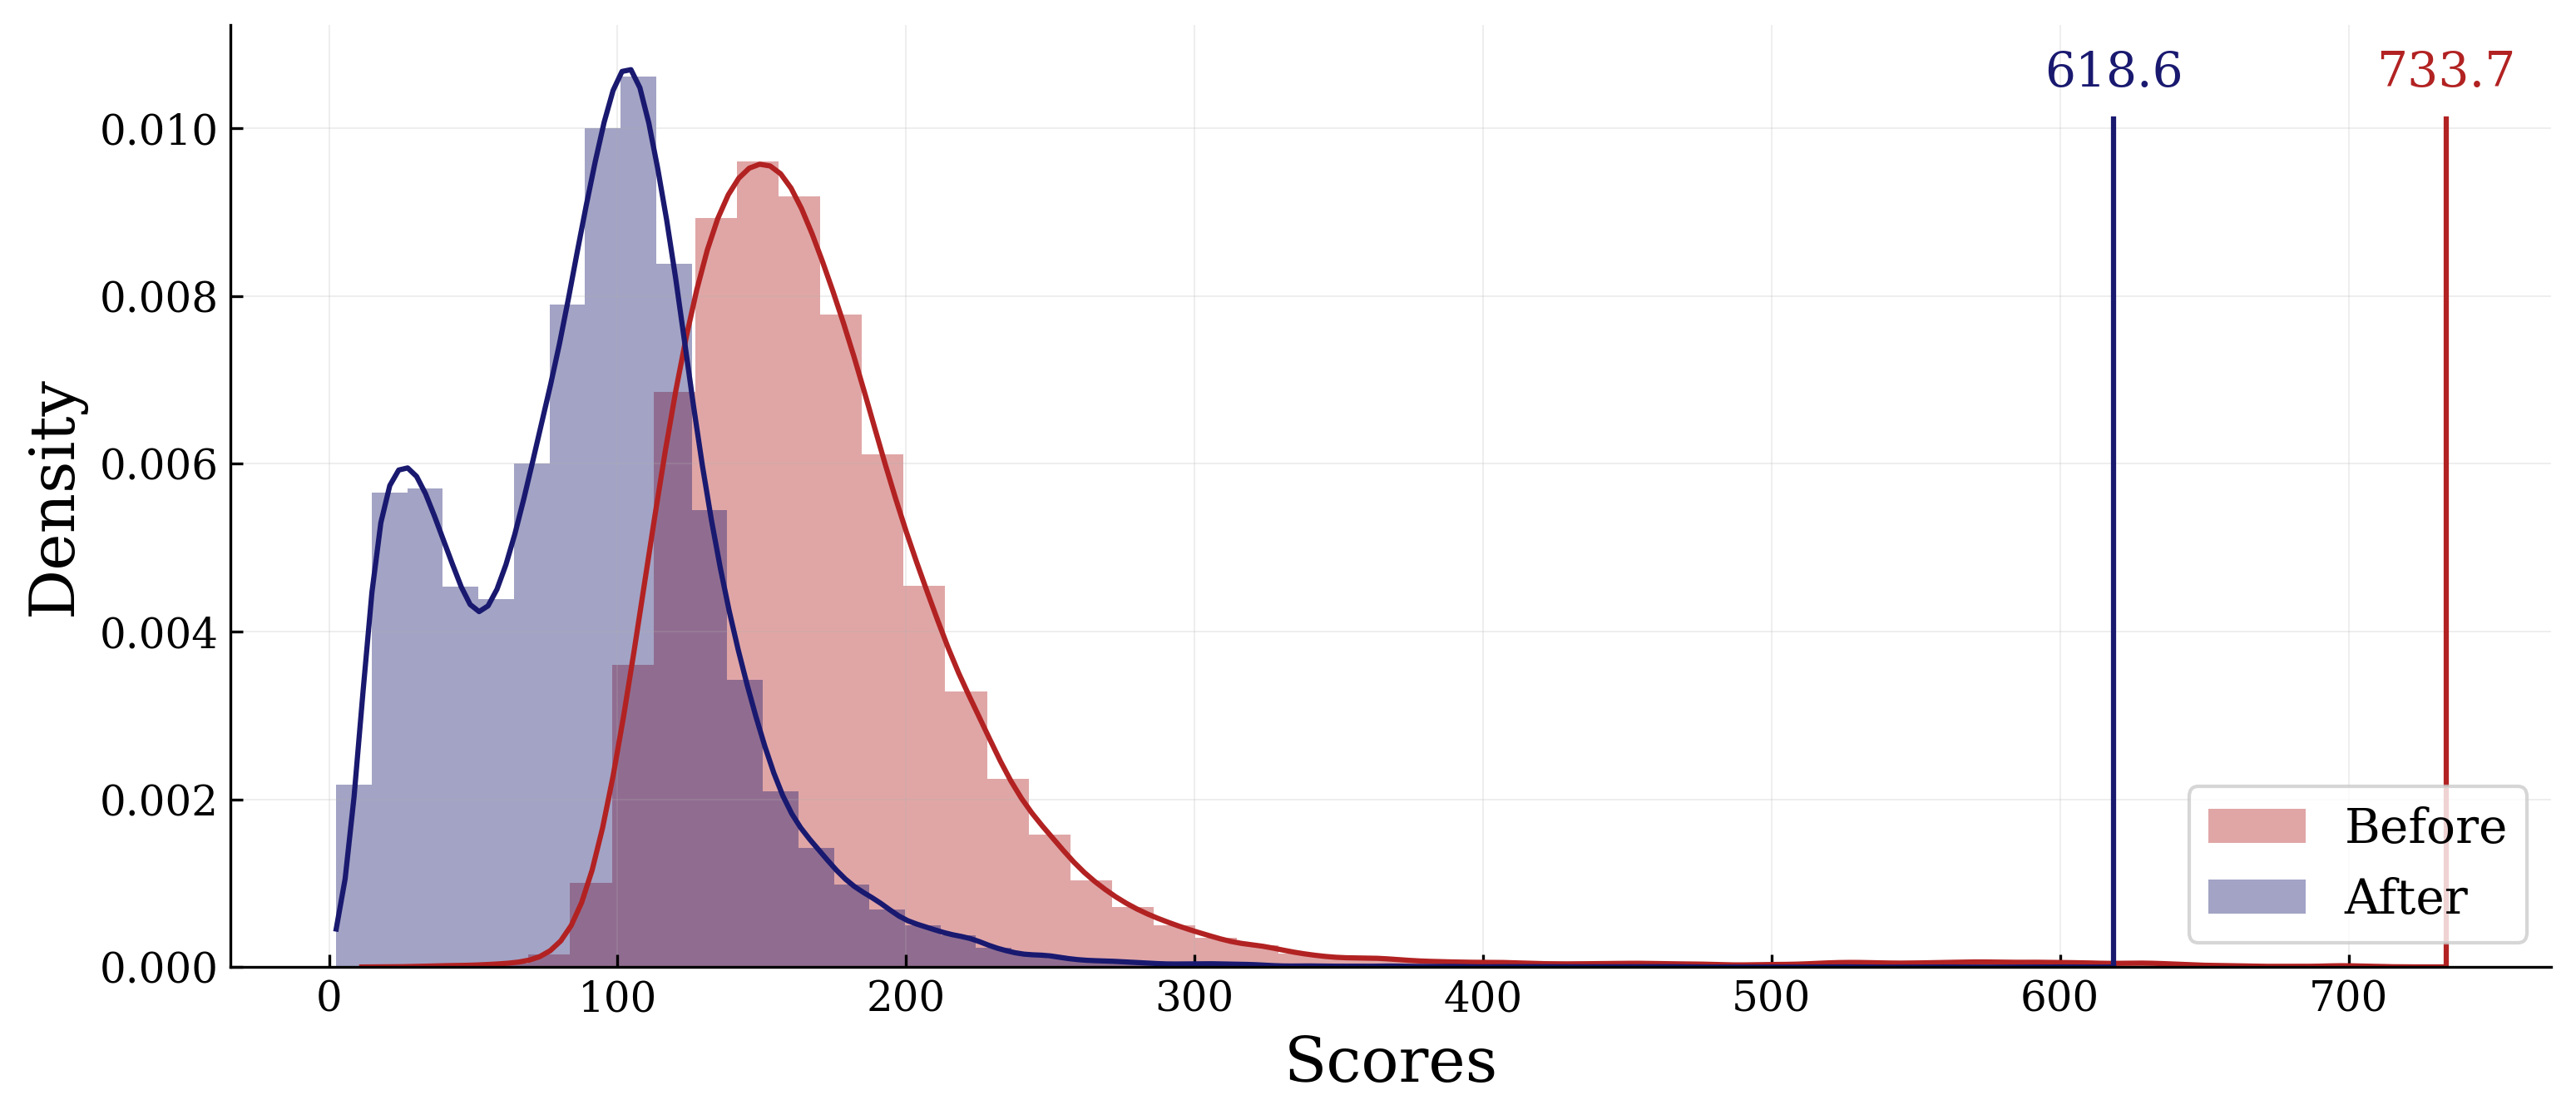

In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(12, 5), facecolor="white", dpi=300)

widths = [5]
heights = [3]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights,
                        wspace=0.03, hspace=0.03)

### 2. setting axes
axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])
    # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment": "center", "color": "gray"})

## Histplot on axs[0]
sns.histplot(data=df_1, x="score", kde=True, ax=axs[0], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="firebrick", label="Before")
sns.histplot(data=df_2, x="score", kde=True, ax=axs[0], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="midnightblue", label="After")

## Vertical lines.
max_1 = max(df_1.loc[:, "score"])
axs[0].axvline(x=max_1, ymin=0, ymax=.9, color="firebrick")
axs[0].text(max_1, 0.0105, f"{max_1:.1f}", fontdict={"horizontalalignment": "center", "color": "firebrick", "fontsize": 14})

max_2 = max(df_2.loc[:, "score"])
axs[0].axvline(x=max_2, ymin=0, ymax=.9, color="midnightblue")
axs[0].text(max_2, 0.0105, f"{max_2:.1f}", fontdict={"horizontalalignment": "center", "color": "midnightblue", "fontsize": 14})

## Other commands.
axs[0].grid(True, lw=.1)
axs[0].tick_params(axis="both", direction="in")
axs[0].set_xlabel("Scores", fontsize=18)
axs[0].set_ylabel("Density", fontsize=18)
axs[0].tick_params(axis="both", labelsize=12)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].legend(loc="lower right", fontsize=14)
# axs[0].set_xlim([-5, 290])
# axs[0].set_ylim([0, 0.021])
# axs[0].set_yticks(list(np.arange(0, 0.021, 0.005)))
# axs[0].yaxis.set_ticklabels(list(np.arange(0, 0.021, 0.005)))
# axs[0].xaxis.set_label_coords(0.5, 0.06, transform=fig.transFigure)

fig.tight_layout()
plt.savefig("1.svg")
plt.show()

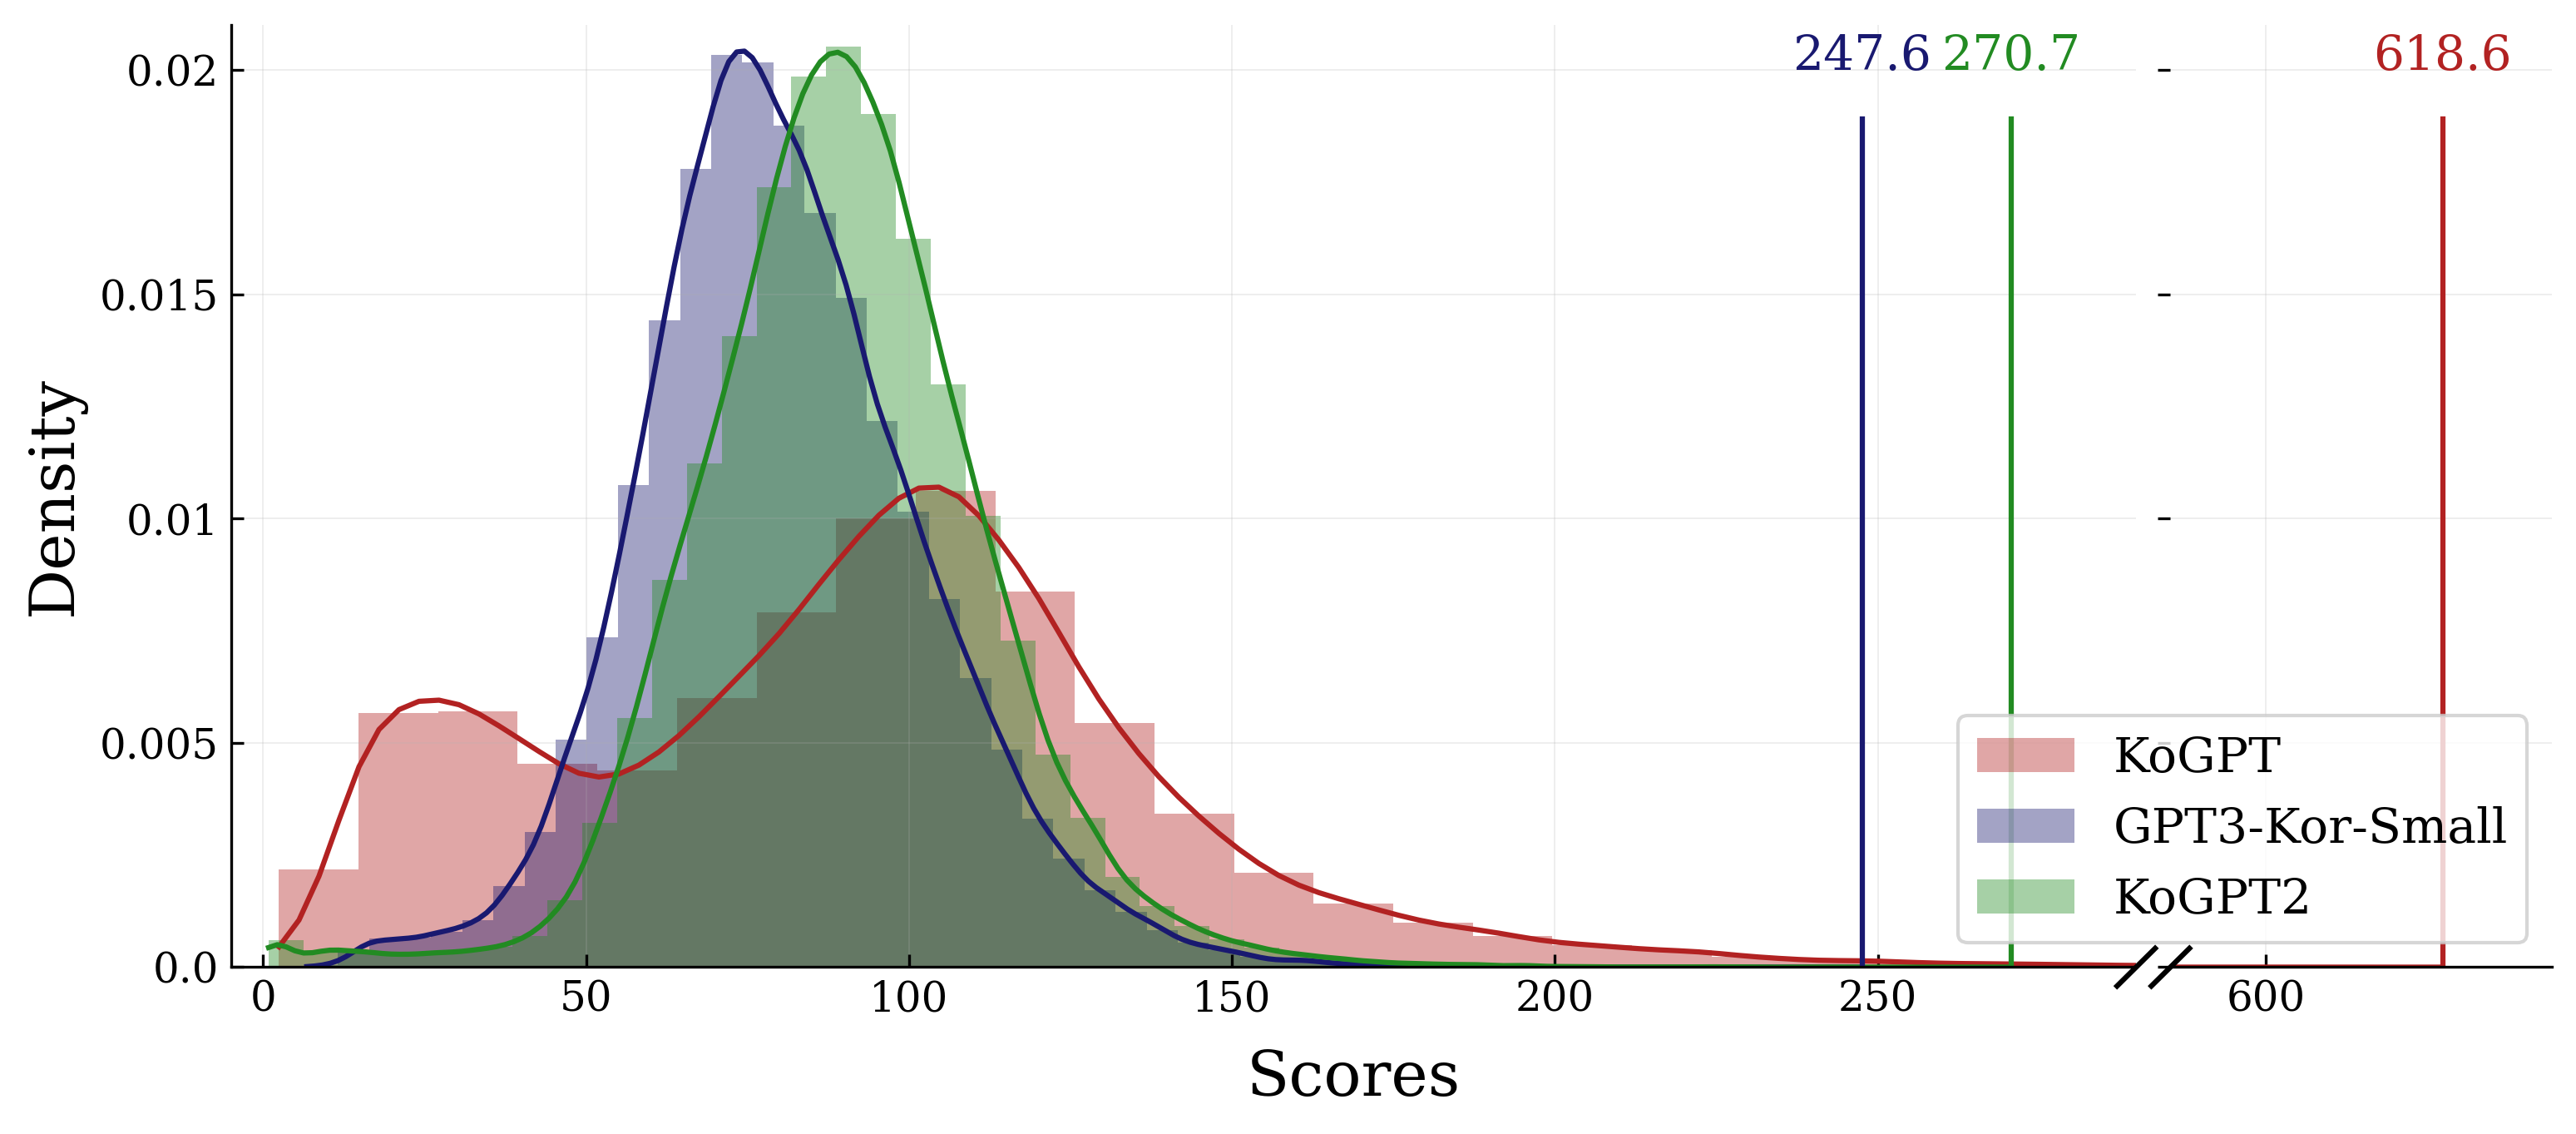

In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(12, 5), facecolor="white", dpi=300)

widths = [5, 1]
heights = [3]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights,
                        wspace=0.03, hspace=0.03)

### 2. setting axes
axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])
    # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment": "center", "color": "gray"})

## Histplot on axs[0]
sns.histplot(data=df_1, x="score", kde=True, ax=axs[0], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="firebrick", label="KoGPT")
sns.histplot(data=df_2, x="score", kde=True, ax=axs[0], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="midnightblue", label="GPT3-Kor-Small")
sns.histplot(data=df_3, x="score", kde=True, ax=axs[0], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="forestgreen", label="KoGPT2")

## Vertical lines.
# max_1 = max(df_1.loc[:, "score"])
# axs[0].axvline(x=max_1, ymin=0, ymax=.9, color="firebrick")
# axs[0].text(max_1, 0.02, f"{max_1:.1f}", fontdict={"horizontalalignment": "center", "color": "firebrick", "fontsize": 14})

max_2 = max(df_2.loc[:, "score"])
axs[0].axvline(x=max_2, ymin=0, ymax=.9, color="midnightblue")
axs[0].text(max_2, 0.02, f"{max_2:.1f}", fontdict={"horizontalalignment": "center", "color": "midnightblue", "fontsize": 14})

max_3 = max(df_3.loc[:, "score"])
axs[0].axvline(x=max_3, ymin=0, ymax=.9, color="forestgreen")
axs[0].text(max_3, 0.02, f"{max_3:.1f}", fontdict={"horizontalalignment": "center", "color": "forestgreen", "fontsize": 14})

## Histplot on axs[0]
g1 = sns.histplot(data=df_1, x="score", kde=True, ax=axs[1], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="firebrick", label="KoGPT")
g2 = sns.histplot(data=df_2, x="score", kde=True, ax=axs[1], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="midnightblue", label="GPT3-Kor-Small")
g3 = sns.histplot(data=df_3, x="score", kde=True, ax=axs[1], bins=50, stat="density", linewidth=0, shrink=1, alpha=.4, color="forestgreen", label="KoGPT2")

g1.set(xlabel=None, ylabel=None)
g2.set(xlabel=None, ylabel=None)
g3.set(xlabel=None, ylabel=None)

## Vertical lines.
max_1 = max(df_1.loc[:, "score"])
axs[1].axvline(x=max_1, ymin=0, ymax=.9, color="firebrick")
axs[1].text(max_1, 0.02, f"{max_1:.1f}", fontdict={"horizontalalignment": "center", "color": "firebrick", "fontsize": 14})

# max_2 = max(df_2.loc[:, "score"])
# axs[1].axvline(x=max_2, ymin=0, ymax=.9, color="midnightblue")
# axs[1].text(max_2, 0.02, f"{max_2:.1f}", fontdict={"horizontalalignment": "center", "color": "midnightblue", "fontsize": 14})

# max_3 = max(df_3.loc[:, "score"])
# axs[1].axvline(x=max_3, ymin=0, ymax=.9, color="forestgreen")
# axs[1].text(max_3, 0.02, f"{max_3:.1f}", fontdict={"horizontalalignment": "center", "color": "forestgreen", "fontsize": 14})

## Other commands.
axs[0].grid(True, lw=.1)
axs[0].tick_params(axis="both", direction="in")
axs[0].set_xlabel("Scores", fontsize=18)
axs[0].set_ylabel("Density", fontsize=18)
axs[0].tick_params(axis="both", labelsize=12)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
# axs[0].legend(loc="lower right", fontsize=14)
axs[0].set_xlim([-5, 290])
axs[0].set_ylim([0, 0.021])
axs[0].set_yticks(list(np.arange(0, 0.021, 0.005)))
axs[0].yaxis.set_ticklabels(list(np.arange(0, 0.021, 0.005)))
axs[0].xaxis.set_label_coords(0.5, 0.06, transform=fig.transFigure)


## Plot two.
axs[1].grid(True, lw=.1)
axs[1].set_xlabel("", fontsize=18)
axs[1].set_ylabel("", fontsize=18)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].legend(loc="lower right", fontsize=14)
axs[1].set_xlim([590, 630])
axs[1].set_ylim([0, 0.021])
axs[1].set_xticks([600])
axs[1].set_yticks(list(np.arange(0, 0.021, 0.005)))
# axs[1].set_yticklabels([])
axs[1].set_yticklabels([])
axs[1].xaxis.set_ticklabels([600])
# axs[1].set_yticks([])
# axs[1].xaxis.set_ticklabels([])
axs[1].tick_params(axis="x", which="both", direction="in", left="off", labelleft=False, labelsize=12)

d = .01 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((1-d,1+d), (-d*2,+d*2), **kwargs)

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d*5,+d*5), (-d*2,+d*2), **kwargs)

# fig.tight_layout()
plt.savefig("1.pdf")
plt.show()

In [ ]:
s = df.loc[:, "score"]
min(s), max(s), np.mean(s), np.std(s)

(2.2382928540402235e-05,
 271.05429516299546,
 87.71749704787933,
 24.586162833826936)

# PLot 2

In [ ]:
def calculate_is_similar(str1: str, str2: str, n_gram: int = 3) -> bool:
    ## Calculate trigram similarity: str1 (reference) vs str2 (hyphothesis).
    ## It is same as "Is string 1 is similar with string 2?"
    str1 = re.split(r"\W+", str1)
    str2 = re.split(r"\W+", str2
                    )
    n_gram_set = lambda x: [set(j for j in x[i:i+n_gram]) for i in range(len(x)-n_gram)]

    s1 = n_gram_set(str1)
    s2 = n_gram_set(str2)

    ## Return true if str1 is similar (or duplicated) to str2 else false.
    ## It is not recommended to mark two strings as similar, trivially.
    return len([i for i in s1 if i in s2]) >= len(s1) / 2


def deduplicate(df: pd.DataFrame) -> pd.DataFrame:
    ## Select and mark top-k.
    top_k_text = []
    top_k_idx = []

    with tqdm.tqdm(desc="Deduplicating", total=100) as pbar:
        for idx, row in df.iterrows():
            ## We only want top-k sentences.
            if len(top_k_text) >= 100:
                break

            ## Big O complexity: O(n(n-1)/2) where n is k.
            if all([not calculate_is_similar(row["text"], text) for text in top_k_text]):
                top_k_text.append(row["text"])  ## save for comparison
                top_k_idx.append(idx)           ## save for marking

                ## Update probress bar.
                pbar.update(1)
    
    df.loc[top_k_idx, "top_k_"] = True
    df.loc[:, "top_k_"] = df.loc[:, "top_k_"].fillna("")

    return df

In [ ]:
df = deduplicate(df)

Deduplicating: 100%|██████████| 100/100 [00:02<00:00, 37.99it/s]


In [ ]:
df = pd.read_csv(args.before.path, encoding="utf-8")
df = df.dropna(subset=["ppl"]).reset_index(drop=True)
df = df.drop(drop_outlier(df.loc[:, "ppl"])[0]).reset_index(drop=True)

p = df.loc[:, "ppl"].values
z = df.loc[:, "zlib"].values

choosen_idx = df.loc[df.loc[:, "top_k"] == True].index
not_choosen_idx = list(set(range(max(choosen_idx))) - set(choosen_idx))

choosen_p = df.loc[choosen_idx, "ppl"].values
choosen_z = df.loc[choosen_idx, "zlib"].values

not_choosen_p = df.loc[not_choosen_idx, "ppl"].values
not_choosen_z = df.loc[not_choosen_idx, "zlib"].values

In [ ]:
aa = sorted(df.loc[not_choosen_idx, "text"].values)
len(aa), len(np.unique(aa))
# aa

(156, 104)

In [ ]:
aa = sorted(df.loc[np.concatenate([choosen_idx, not_choosen_idx]), "text"].values)
len(aa), len(np.unique(aa))

(256, 192)

In [ ]:
def my_printer(df):
    p = df.loc[:, "ppl"].values
    z = df.loc[:, "zlib"].values

    ## My
    choosen_idx = df.loc[df.loc[:, "top_k"] == True].index
    not_choosen_idx = list(set(range(max(choosen_idx))) - set(choosen_idx))

    choosen_p = df.loc[choosen_idx, "ppl"].values
    choosen_z = df.loc[choosen_idx, "zlib"].values

    not_choosen_p = df.loc[not_choosen_idx, "ppl"].values
    not_choosen_z = df.loc[not_choosen_idx, "zlib"].values

    ## Carlini
    choosen_idx_ = df.loc[df.loc[:, "top_k_"] == True].index
    not_choosen_idx_ = list(set(range(max(choosen_idx_))) - set(choosen_idx_))

    choosen_p_ = df.loc[choosen_idx_, "ppl"].values
    choosen_z_ = df.loc[choosen_idx_, "zlib"].values

    not_choosen_p_ = df.loc[not_choosen_idx_, "ppl"].values
    not_choosen_z_ = df.loc[not_choosen_idx_, "zlib"].values

    print("\n\n")
    print(f"{len(p)} & {len(choosen_p_)} & {len(not_choosen_p_)} & {len(choosen_p)} & {len(not_choosen_p)} \\")
    print(f"{np.mean(p):.2f} & {np.mean(choosen_p_):.2f} & {np.mean(not_choosen_p_):.2f} & {np.mean(choosen_p):.2f} & {np.mean(not_choosen_p):.2f} \\")
    print(f"{np.mean(z):.0f} & {np.mean(choosen_z_):.0f} & {np.mean(not_choosen_z_):.0f} & {np.mean(choosen_z):.0f} & {np.mean(not_choosen_z):.0f} \\")

In [ ]:
kykim_kogpt3
skt_kogpt2

In [ ]:
df = pd.read_csv(args.before.path, encoding="utf-8")
df = df.dropna(subset=["ppl"]).reset_index(drop=True)
df = df.drop(drop_outlier(df.loc[:, "ppl"])[0]).reset_index(drop=True)

df = deduplicate(df)

my_printer(df)

Deduplicating: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]




99155 & 100 & 143 & 100 & 156 \
3.73 & 1.07 & 1.05 & 1.07 & 1.05 \
604 & 686 & 686 & 683 & 685 \


In [ ]:
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(12, 8), facecolor="white", dpi=300)

widths = [5, .5]
heights = [.5, 5]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

### 2. setting axes
axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])
    # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment": "center", "color": "gray"})

## Scatter Plot in axs[2]
axs[2].scatter(p, z, s=1, marker="o", color="grey", alpha=.1)
axs[2].scatter(choosen_p, choosen_z, s=50, marker="o", edgecolor="k", linewidths=.5, color="firebrick", alpha=.8)
axs[2].scatter(not_choosen_p, not_choosen_z, s=50, marker="x", edgecolor="k", linewidths=.5, color="midnightblue", alpha=.8)

axs[2].scatter(None, None, s=50, marker="o", color="grey", label="All Samples")
axs[2].scatter(None, None, s=50, marker="o", edgecolor="k", linewidths=.5, color="firebrick", label=f"Selected (#: {len(choosen_idx)})")
axs[2].scatter(None, None, s=50, marker="x", edgecolor="k", linewidths=.5, color="midnightblue", label=f"Deduplicated (#: {len(not_choosen_idx)})")

axs[2].grid(True, lw=.1)
axs[2].tick_params(axis="both", direction="in")
axs[2].set_xlabel("Perplexity", fontsize=18)
axs[2].set_ylabel("zlib Entropy", fontsize=18)
axs[2].legend(loc="upper left", fontsize=14)

axs[2].set_xlim([0.9, 15])
axs[2].set_ylim([-5, 900])
axs[2].set_xscale("log")
axs[2].set_xticks(list(range(1, 10+1, 1)) + [15])
axs[2].xaxis.set_ticklabels(list(range(1, 10+1, 1)) + [15])
axs[2].tick_params(axis="both", labelsize=14)

## KDE Plot in axs[2]
sns.kdeplot(x="ppl", y="zlib", data=df, color="k", ax=axs[2], shade=False, alpha=.1, levels=20)

## Histogram params
params = {
    "bins": 100,
    "color": "grey",
    "alpha": .3,
    "rwidth": 1,
    "edgecolor": "k",
}

## Histogram - PPL.

# axs[0].hist(p, range=[0.9, 10], **params)
axs[0].set_xscale("log")
axs[0].spines["left"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].set_xlim([0.9, 15])
axs[0].get_yaxis().set_visible(False)
## Plot after tick setting.
sns.kdeplot(x="ppl", data=df, ax=axs[0], legend=False, shade=True, color="grey")
axs[0].set_xlabel("")
axs[0].set_xticklabels([])
axs[0].tick_params(axis="both", direction="in")

## Histogram - zlib Entropy.
# axs[3].hist(z, range=[-10, 900], orientation="horizontal", **params)
axs[3].spines["bottom"].set_visible(False)
axs[3].spines["right"].set_visible(False)
axs[3].spines["top"].set_visible(False)
axs[3].set_ylim([-5, 900])
axs[3].get_xaxis().set_visible(False)
axs[3].yaxis.set_ticklabels([])
axs[3].tick_params(axis="both", direction="in")
sns.kdeplot(y="zlib", data=df, ax=axs[3], legend=False, shade=True, color="grey")
axs[3].set_ylabel("")
axs[3].set_yticklabels([])

## Hide empty axes.
axs[1].axis("off")

fig.tight_layout()
plt.savefig("2-1.pdf")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df = pd.read_csv(args.after.path, encoding="utf-8")
df = df.dropna(subset=["ppl"]).reset_index(drop=True)
df = df.drop(drop_outlier(df.loc[:, "ppl"])[0]).reset_index(drop=True)

p = df.loc[:, "ppl"].values
z = df.loc[:, "zlib"].values

choosen_idx = df.loc[df.loc[:, "top_k"] == True].index
not_choosen_idx = list(set(range(max(choosen_idx))) - set(choosen_idx))

choosen_p = df.loc[choosen_idx, "ppl"].values
choosen_z = df.loc[choosen_idx, "zlib"].values

not_choosen_p = df.loc[not_choosen_idx, "ppl"].values
not_choosen_z = df.loc[not_choosen_idx, "zlib"].values

plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(12, 8), facecolor="white", dpi=300)

widths = [5, .5]
heights = [.5, 5]

### 1. gridspec preparation
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

### 2. setting axes
axs = {}
for i in range(len(heights)*len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])
    # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment": "center", "color": "gray"})

## Scatter Plot in axs[2]
axs[2].scatter(p, z, s=1, marker="o", color="grey", alpha=.1)
axs[2].scatter(choosen_p, choosen_z, s=50, marker="o", edgecolor="k", linewidths=.5, color="firebrick", alpha=.8)
axs[2].scatter(not_choosen_p, not_choosen_z, s=50, marker="x", edgecolor="k", linewidths=.5, color="midnightblue", alpha=.8)

axs[2].scatter(None, None, s=50, marker="o", color="grey", label="All Samples")
axs[2].scatter(None, None, s=50, marker="o", edgecolor="k", linewidths=.5, color="firebrick", label=f"Selected (#: {len(choosen_idx)})")
axs[2].scatter(None, None, s=50, marker="x", edgecolor="k", linewidths=.5, color="midnightblue", label=f"Deduplicated (#: {len(not_choosen_idx)})")

axs[2].grid(True, lw=.1)
axs[2].tick_params(axis="both", direction="in")
axs[2].set_xlabel("Perplexity", fontsize=18)
axs[2].set_ylabel("zlib Entropy", fontsize=18)
axs[2].legend(loc="lower right", fontsize=14)

axs[2].set_xlim([0.9, 15])
axs[2].set_ylim([-5, 900])
axs[2].set_xscale("log")
axs[2].set_xticks(list(range(1, 10+1, 1)) + [15])
axs[2].xaxis.set_ticklabels(list(range(1, 10+1, 1)) + [15])
axs[2].tick_params(axis="both", labelsize=14)

## KDE Plot in axs[2]
sns.kdeplot(x="ppl", y="zlib", data=df, color="k", ax=axs[2], shade=False, alpha=.1, levels=20)

## Histogram params
params = {
    "bins": 100,
    "color": "grey",
    "alpha": .3,
    "rwidth": 1,
    "edgecolor": "k",
}

## Histogram - PPL.

# axs[0].hist(p, range=[0.9, 10], **params)
axs[0].set_xscale("log")
axs[0].spines["left"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].set_xlim([0.9, 15])
axs[0].get_yaxis().set_visible(False)
## Plot after tick setting.
sns.kdeplot(x="ppl", data=df, ax=axs[0], legend=False, shade=True, color="grey")
axs[0].set_xlabel("")
axs[0].set_xticklabels([])
axs[0].tick_params(axis="both", direction="in")

## Histogram - zlib Entropy.
# axs[3].hist(z, range=[-10, 900], orientation="horizontal", **params)
axs[3].spines["bottom"].set_visible(False)
axs[3].spines["right"].set_visible(False)
axs[3].spines["top"].set_visible(False)
axs[3].set_ylim([-5, 900])
axs[3].get_xaxis().set_visible(False)
axs[3].yaxis.set_ticklabels([])
axs[3].tick_params(axis="both", direction="in")
sns.kdeplot(y="zlib", data=df, ax=axs[3], legend=False, shade=True, color="grey")
axs[3].set_ylabel("")
axs[3].set_yticklabels([])

## Hide empty axes.
axs[1].axis("off")

fig.tight_layout()
plt.savefig("bb.png")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

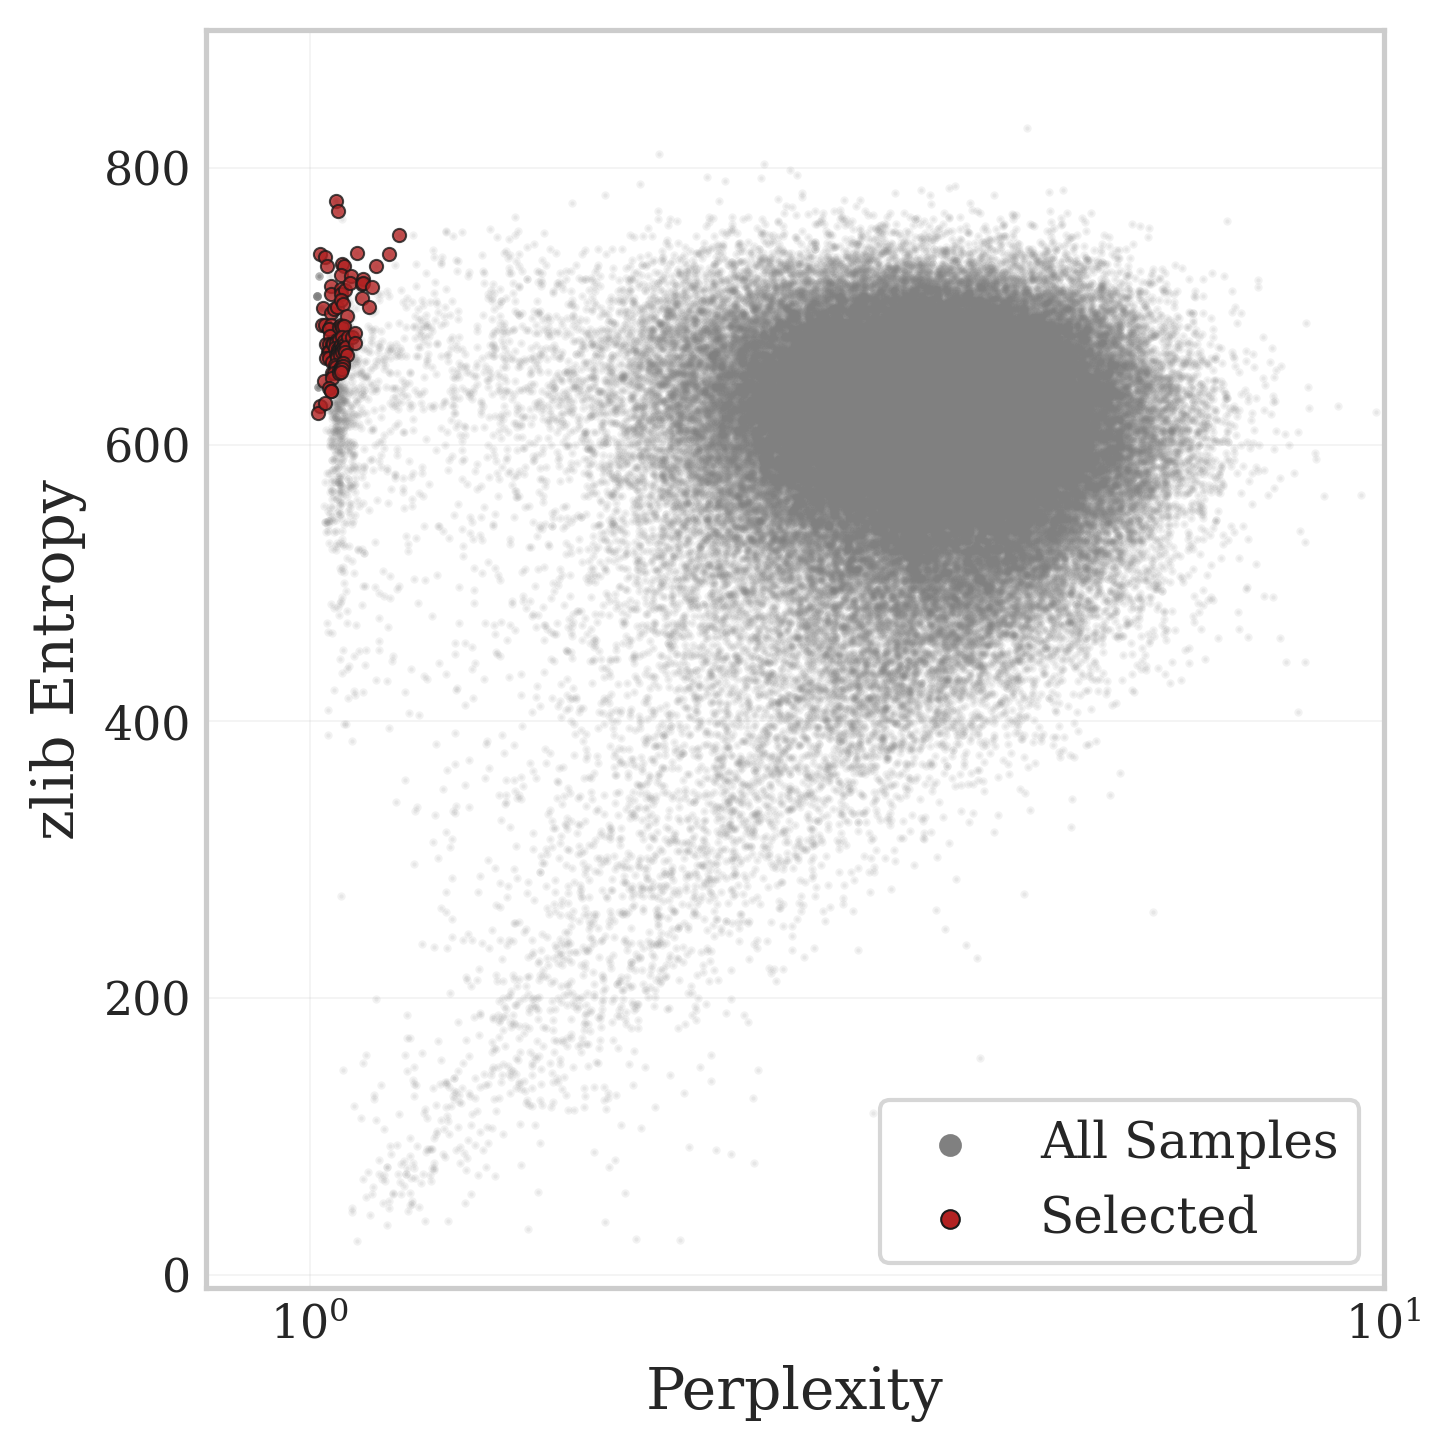

In [ ]:
plt.rcParams["font.family"] = "serif"
fig, axs = plt.subplots(figsize=(5, 5), facecolor="white", dpi=300)

df = pd.read_csv(args.kakaobrain_kogpt.path, encoding="utf-8")

p = df.loc[:, "ppl"].values
z = df.loc[:, "zlib"].values

choosen_idx = df.loc[df.loc[:, "top_k"] == True].index
not_choosen_idx = list(set(range(max(choosen_idx))) - set(choosen_idx))

choosen_p = df.loc[choosen_idx, "ppl"].values
choosen_z = df.loc[choosen_idx, "zlib"].values

not_choosen_p = df.loc[not_choosen_idx, "ppl"].values
not_choosen_z = df.loc[not_choosen_idx, "zlib"].values

axs.scatter(p, z, s=1, marker="o", color="grey", alpha=.1)
axs.scatter(choosen_p, choosen_z, s=10, marker="o", edgecolor="k", linewidths=.5, color="firebrick", alpha=.8)
# axs.scatter(not_choosen_p, not_choosen_z, s=10, marker="o", edgecolor="k", linewidths=.5, color="midnightblue", alpha=.8)

axs.scatter(None, None, s=20, marker="o", color="grey", label="All Samples")
axs.scatter(None, None, s=20, marker="o", edgecolor="k", linewidths=.5, color="firebrick", label="Selected")
# axs.scatter(None, None, s=20, marker="x", color="midnightblue", label="Duplicated")

axs.grid(True, lw=.1)
axs.tick_params(axis="both", direction="in")
axs.set_xlabel("Perplexity", fontsize=14)
axs.set_ylabel("zlib Entropy", fontsize=14)
axs.legend(loc="lower right", fontsize=12)

axs.set_xlim([0.8, 10])
axs.set_ylim([-10, 900])
axs.set_xscale("log")

fig.tight_layout()
plt.savefig("2.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


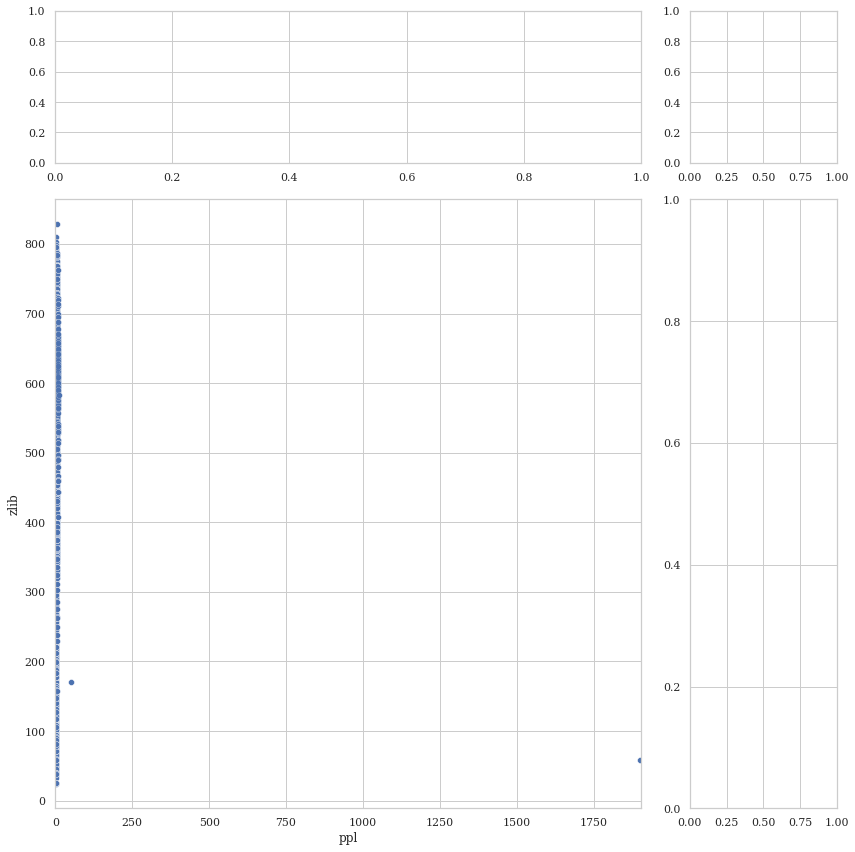

In [ ]:
fig = plt.figure(figsize=(12, 12), facecolor="white")

widths = [4, 1]
heights = [1, 4]

## 1. gridspec preparation
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

## 2. setting axes
axs = {}
for i in range(len(heights) * len(widths)):
    axs[i] = fig.add_subplot(spec[i // len(widths), i % len(widths)])

# 3. bill_length_mm vs bill_depth_mm
# 3.1. kdeplot
sns.kdeplot(x="ppl", y="zlib", data=df, alpha=0.3, ax=axs[2])
# 3.2. scatterplot
sns.scatterplot(x="ppl", y="zlib", data=df, ax=axs[2])

fig.tight_layout()

Text(0.5, 1.0, 'Kernel Density Plot')

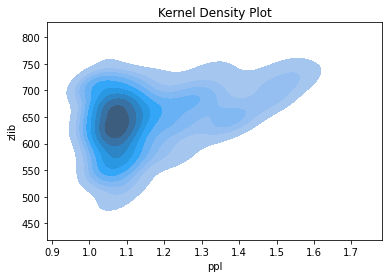

In [ ]:
kde, ax = plt.subplots()
ax = sns.kdeplot(x="ppl", y="zlib", data=df.loc[:1000], shade=True) # shade=True 
ax.set_title('Kernel Density Plot')

In [ ]:
import easydict

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/ColabNotebooks/mia/KoGPT6B-ryan1.5b-float16-20220411-124812-100000.csv" "./KoGPT6B-ryan1.5b-float16-20220411-124812-100000.csv"
!cp "/content/drive/MyDrive/ColabNotebooks/mia/skt-ko-gpt-trinity-1.2B-v0.5-20220417-140929-100000.csv" "./skt-ko-gpt-trinity-1.2B-v0.5-20220417-140929-100000.csv"
!cp "/content/drive/MyDrive/ColabNotebooks/mia/skt-kogpt2-base-v2-20220420-094513-100000.csv" "./skt-kogpt2-base-v2-20220420-094513-100000.csv"

In [ ]:
args = easydict.EasyDict({
    "kakaobrain_kogpt": {
        "path": "./KoGPT6B-ryan1.5b-float16-20220411-124812-100000.csv",
    },
    "skt_kogpt_trinity": {
        "path": "./skt-ko-gpt-trinity-1.2B-v0.5-20220417-140929-100000.csv",
    },
    "skt_kogpt_2": {
        "path": "./skt-kogpt2-base-v2-20220420-094513-100000.csv",
    },
})

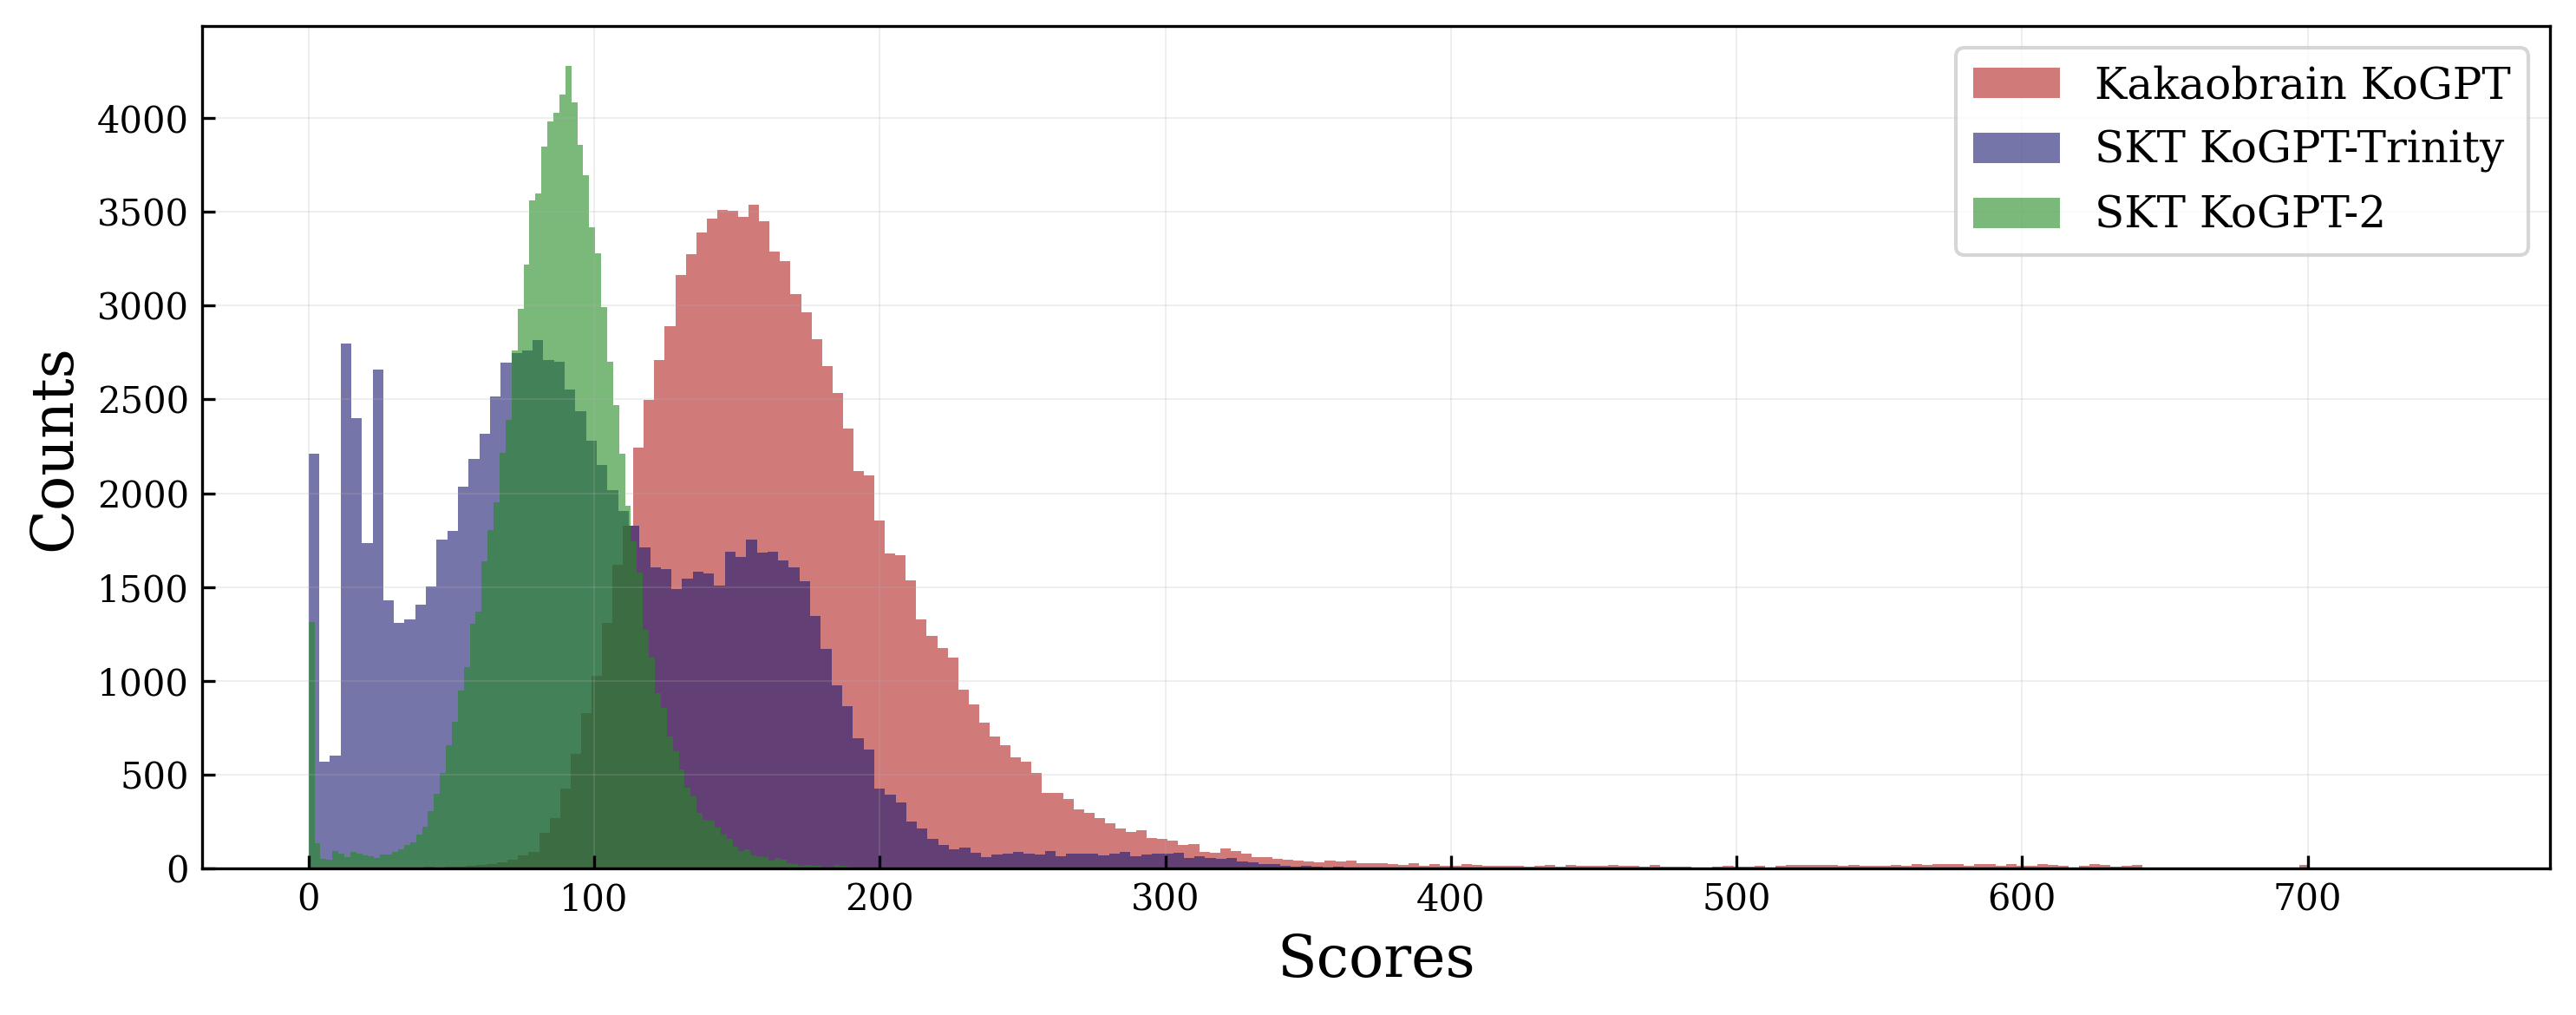

In [ ]:
plt.rcParams["font.family"] = "serif"
fig, axs = plt.subplots(figsize=(10, 4), facecolor="white", dpi=300)

model_names = ["Kakaobrain KoGPT", "SKT KoGPT-Trinity", "SKT KoGPT-2"]
colors = ["firebrick", "midnightblue", "forestgreen"]

for model, model_name, c in zip(args.keys(), model_names, colors):
    df = pd.read_csv(args.get(model).path, encoding="utf-8")
    s = df.loc[:, "score"].dropna().values

    axs.hist(s, bins=200, color=c, alpha=.6, label=model_name)

axs.grid(True, lw=.1)
axs.tick_params(axis="both", direction="in")
axs.legend(loc="upper right", fontsize=12)
axs.set_xlabel("Scores", fontsize=16)
axs.set_ylabel("Counts", fontsize=16)

fig.tight_layout()
plt.savefig("2.svg")
plt.show()

In [ ]:
for model, model_name, c in zip(args.keys(), model_names, colors):
    df = pd.read_csv(args.get(model).path, encoding="utf-8")
    s = df.loc[:, "score"].dropna().values
    
    mu = np.mean(s)
    sigma = np.std(s)
    mx = np.max(s)
    print(f"model: {model_name}, mean: {mu:.1f}, std: {sigma:.1f}, max: {mx:.1f}")

model: Kakaobrain KoGPT, mean: 173.1, std: 62.8, max: 733.7
model: SKT KoGPT-Trinity, mean: 98.8, std: 60.5, max: 747.5
model: SKT KoGPT-2, mean: 87.8, std: 24.8, max: 418.2


In [ ]:
df.head()

,text,ppl,zlib,score,top_k
0,"한신공영은 5월 10일 13시 7분 전일 대비 약 5% 상승한 3,750원에 거래되...",1.824468,763,418.204152,True
1,'모건스탠리 아시아ᆞ태평양(Asia-Pacific)'에 한국계 은행인 한국씨티은행이...,2.208218,696,315.186224,True
2,"주가는 전일 대비 -6.32% 하락한 3,230원을 기록했다.\n주가의 흐름을 살펴...",2.427209,702,289.221060,True
3,. 코오롱스포츠(073240)의 당일 거래량이 최근 5거래일 거래량의 최고치를 경신...,2.661038,728,273.577462,True
4,"롯데쇼핑(023530)에 대해 ""2분기에는 영업이익이 전년 동기 대비 13% 하락했...",2.897638,755,260.557061,True


In [ ]:
df.loc[:, "top_k"].unique()

array([True, nan], dtype=object)

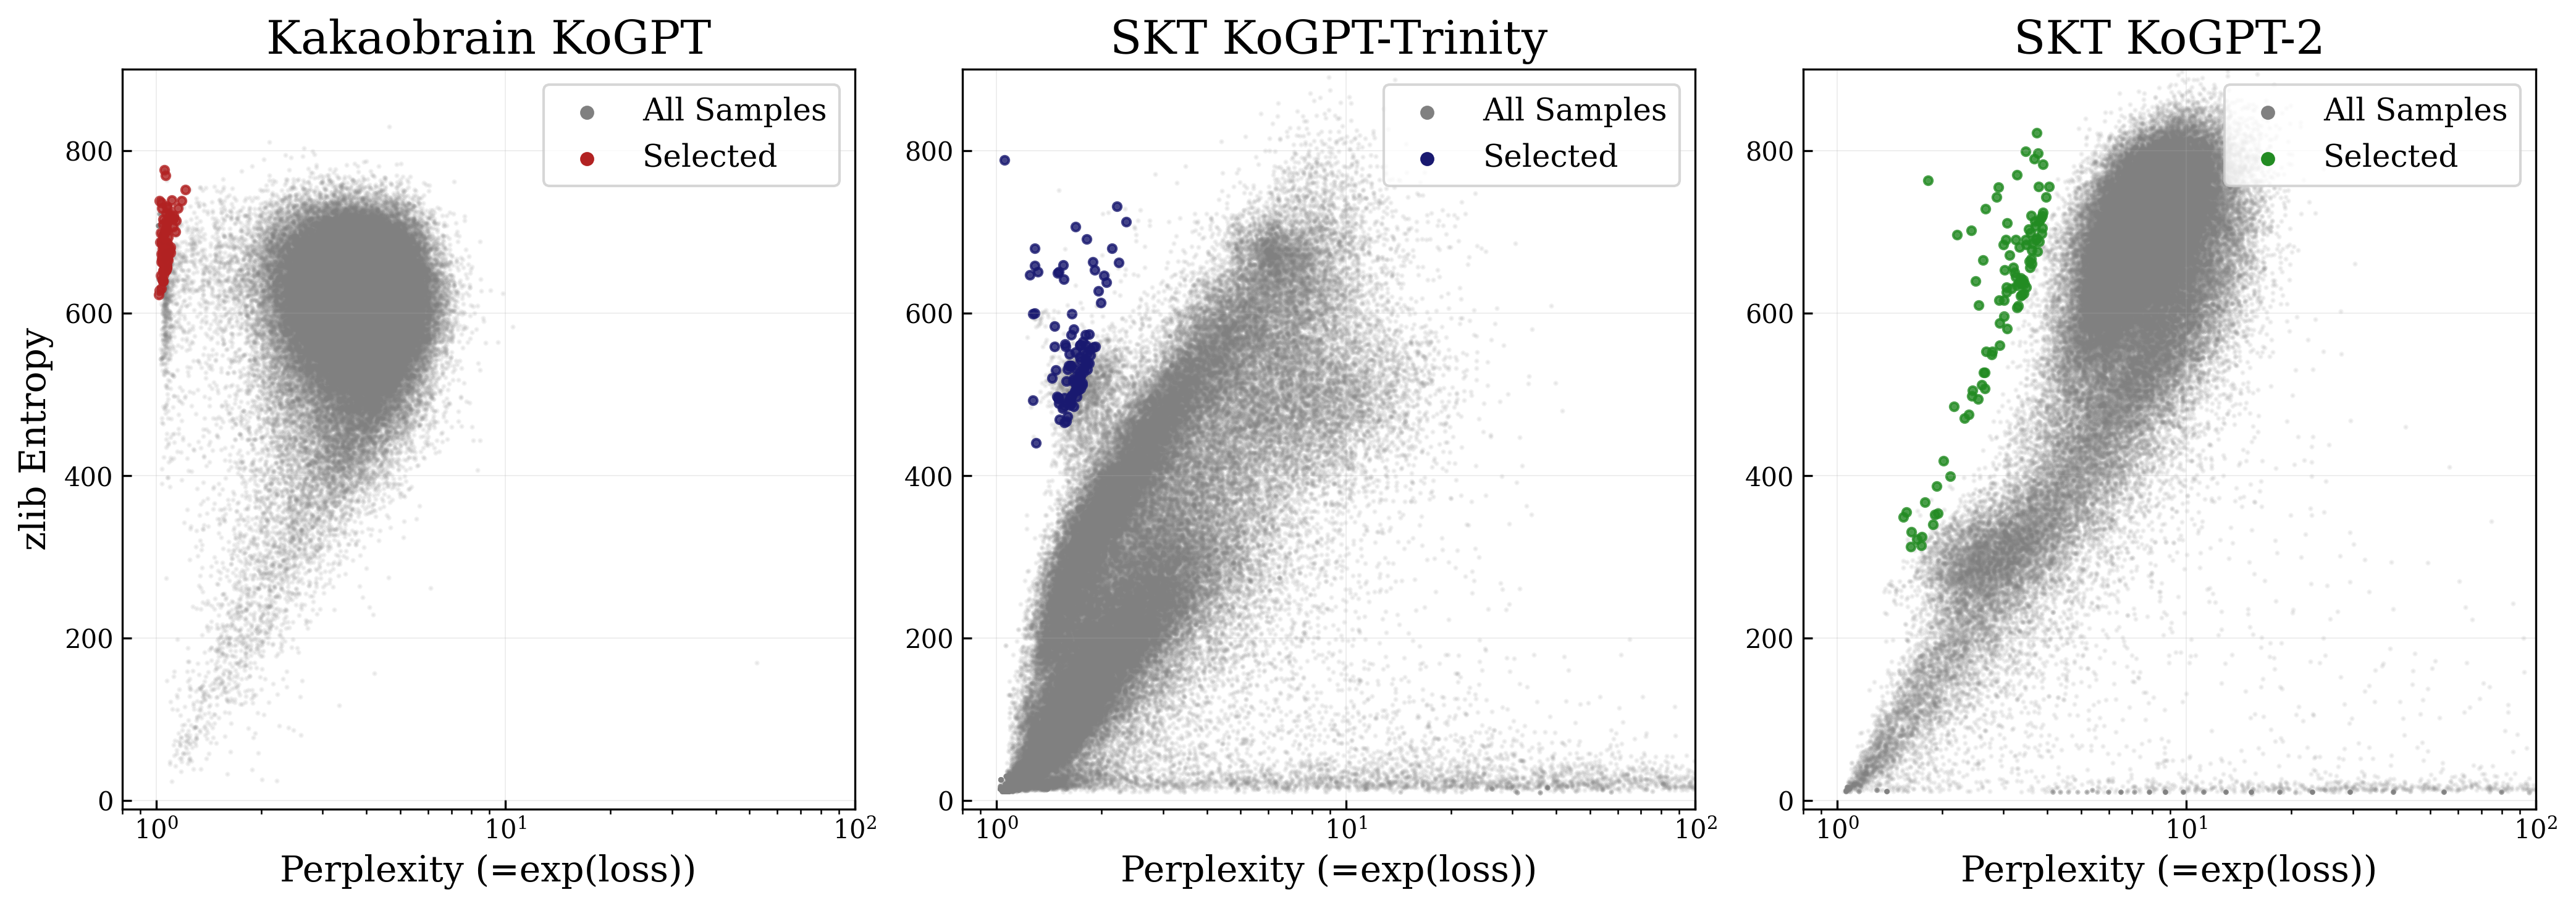

In [ ]:
plt.rcParams["font.family"] = "serif"
fig, axs = plt.subplots(1, 3, figsize=(14, 5), facecolor="white", dpi=300)

model_names = ["Kakaobrain KoGPT", "SKT KoGPT-Trinity", "SKT KoGPT-2"]
colors = ["firebrick", "midnightblue", "forestgreen"]

for model, model_name, c, ax in zip(args.keys(), model_names, colors, axs):
    df = pd.read_csv(args.get(model).path, encoding="utf-8")
    
    p = df.loc[:, "ppl"].values
    z = df.loc[:, "zlib"].values

    choosen_p = df.loc[df.loc[:, "top_k"] == True, "ppl"].values
    choosen_z = df.loc[df.loc[:, "top_k"] == True, "zlib"].values

    ax.set_title(model_name, fontsize=18)
    ax.scatter(p, z, s=1, color="grey", alpha=.1)
    ax.scatter(choosen_p, choosen_z, s=10, color=c, alpha=.8)

    ax.scatter(None, None, s=20, color="grey", label="All Samples")
    ax.scatter(None, None, s=20, color=c, label="Selected")

    ax.grid(True, lw=.1)
    ax.tick_params(axis="both", direction="in")
    ax.set_xlabel("Perplexity (=exp(loss))", fontsize=14)
    if model_name == "Kakaobrain KoGPT":
        ax.set_ylabel("zlib Entropy", fontsize=14)
    ax.legend(loc="upper right", fontsize=12)
    
    ax.set_xlim([0.8, 100])
    ax.set_ylim([-10, 900])
    ax.set_xscale("log")

fig.tight_layout()
plt.savefig("1.pdf")
plt.show()